# Analysis of Cross-Sectional Data

### Kevin Sheppard 


# Course Structure

* Course presented through three channels:
    1. Pre-recorded content with a focus on technical aspects of the course
        * Designed to be viewed in sequence
        * Each module should be short
        * Approximately 2 hours of content per week
    2. In-person lectures with a focus on applied aspects of the course
        * Expected that pre-recorded content has been viewed before the lecture
    3. Notes that accompany the lecture content
        * Read before or after the lecture or when necessary for additional background
* Slides are primary – material presented during lecturers, either pre-recorded or live is examinable
* Notes are secondary and provide more background for the slides
* Slides are derived from notes so there is a strong correspondence

# Monitoring Your Progress

* Self assessment
    * Review questions in pre-recorded content
    * Multiple choice questions on Canvas made available each week
        * Answers available immediately
    * Long-form problem distributed each week
        * Answers presented in a subsequent class
* Marked Assessment
    * Empirical projects applying the material in the lectures
    * Both individual and group
    * Each empirical assignment will have a written and code component

# Analysis of Cross-Sectional Data

## Introduction to Regression Models

* Notation
* Factor Models
* Data
* Variable Transformations

# Linear Regression

## Scalar Notation

$$ Y_{i}=\beta_{1}X_{1,i}+\beta_{2}X_{2,i}+\ldots+\beta_{k}X_{k,i}+\epsilon_{i} $$

* $Y_{i}$: Regressand, Dependent Variable, LHS Variable 
* $X_{j,i}$: Regressor, also Independent Variable, RHS Variable, Explanatory Variable 
* $\epsilon_{i}$: Innovation, also Shock, Error or Disturbance 
* $n$ observations, indexed $i=1,2,\ldots,n$ 
* $k$ regressors, indexed $j=1,2,\ldots,k$ 


# Linear Regression

## Matrix Notation

Common to use convenient matrix notation

$$ \mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\epsilon} $$

* $\mathbf{y}$ is $n$ by $1$
* $\mathbf{X}$  is $n$ by $k$
* $\boldsymbol{\beta}$ is $k$ by $1$
* $\boldsymbol{\epsilon}$ is $n$ by $1$

# Factor Models

* Factor models are widely used in finance 

    * Capital Asset Pricing Model (CAPM) 
    * Arbitrage Pricing (APT) 
    * Risk Exposure 

* Basic specification $R_{i}=\mathbf{f}_{i}\boldsymbol{\beta}+\epsilon_{i}$

    * $R_{i}$: Return on dependent asset, often excess $(R_{i}^{e})$ 
    * $\mathbf{f}_{i}$: $1\times k$ vector of factor innovations 
    * $\epsilon_{i}$ innovation, $corr(\epsilon_{i},F_{j,i})=0$, $j=1,2,\ldots,k $

* Special Case: CAPM 
$$R_{i}-R_{i}^{f}=\beta(R_{i}^{m}-R_{i}^{f})+\epsilon_{i} $$
$$R_{i}^{e}=\beta R_{i}^{me}+\epsilon_{i}$$

# Data

* Data from the Fama-French 3 factors + Momentum
   * $VWM^e$ - Excess return on Value-Weighted-Market
   * $SMB$ - Return on the size portfolio
   * $HML$ - Return on the value portfolio
   * $MOM$ - Return on the momentum portfolio
* Size-Value sorted portfolio return data
    * Size
        * S: Small
        * B: Big
    * Value
        * H: High BE/ME
        * M: Middle BE/ME
        * L: Low BE/ME
* 49 Industry Portfolios
* All returns excess except $SMB$, $HML$, $MOM$

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix as pd_scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import mfe
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

mfe.full_setup()
mfe.outputs["pres"]()
DEFAULT_FIGSIZE = (32, 15)
plt.rc("figure", figsize=DEFAULT_FIGSIZE)
plt.rc("font", size=48)
factors = pd.read_hdf("data/fama-data.h5", "factors").resample("M").last()
ports = pd.read_hdf("data/fama-data.h5", "portfolios").resample("M").last()

components = ports.iloc[:, :6]
industries = ports.iloc[:, 6:]
data = pd.concat([factors, ports], axis=1)
data = data.resample("M").last()
subset = industries.iloc[:, 4::5]


def clean(s):
    return s.replace("$", "").replace("^e", "e")


data.columns = [clean(c) for c in data.columns]


def pretty(s):
    from IPython.display import display, HTML
    if not isinstance(s, pd.Series):
        return display(HTML(f"<span>{s}</span>"))
    
    df = pd.DataFrame(s)
    if df.columns[0] == 0:
        df.columns = [""]
    return df


def scatter_matrix(*args, **kwargs):
    plts = pd_scatter_matrix(*args, **kwargs)
    for i in range(4):
        ax = plts[i, 0]
        # ax.set_yticks([])
        ax = plts[-1, i]
        # ax.set_xticks([])
    ax.get_figure().tight_layout(pad=1.0)
    return None


def scatter(y):
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    for i in range(3):
        ax[i].scatter(factors["$VWM^e$"], factors.iloc[:, i + 1], color=mfe.colors[i])
        ax[i].set_title(f"$VWM^e$ vs. {factors.iloc[:,i+1].name}")
    fig.tight_layout(pad=1.0)


def figsize(x=DEFAULT_FIGSIZE[0], y=DEFAULT_FIGSIZE[1]):
    plt.rc("figure", figsize=(x, y))
    
def test_plot(t, ax=None, color=None, title="$t$-test statistics", cv=None, show_cv=True, two_sided=False):
    idx = t.index
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.get_figure()
    cv = cv if cv is not None else stats.norm().ppf(0.975)
    base_color = color if color is not None else mfe.colors[0]
    n = len(idx)
    colors = [base_color if np.abs(s) > cv else base_color + (0.2,) for s in t]
    ax.barh(np.arange(n), t, align="center", color=colors, edgecolor=mfe.colors[0])
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(t.index)
    ax.set_title(title)
    if show_cv:
        ylim = ax.get_ylim()
        ax.plot([cv,cv],ylim,"k--",zorder=10)
        if two_sided:
            ax.plot([-cv,-cv],ylim,"k--",zorder=10)
        ax.set_ylim(ylim)
    fig.tight_layout(pad=1.0)

In [2]:
def summ_plot(df, idx=None):
    if idx is None:
        idx = np.arange(df.shape[1])
    mu = (12 * df.mean()).sort_values()
    std = np.sqrt(12) * (df).std()
    std = std.reindex_like(mu)
    skew = df.skew()
    skew = skew.reindex_like(mu)
    kurt = df.kurtosis()
    kurt = kurt.reindex_like(mu)

    fig, ax = plt.subplots(1, 4)
    n = len(idx)
    ax[0].barh(np.arange(n), mu.iloc[idx], align="center")
    ax[0].set_yticks(np.arange(n))
    _ = ax[0].set_yticklabels(mu.iloc[idx].index)
    ax[0].set_title("Ann. Return")

    ax[1].barh(np.arange(n), std.iloc[idx], align="center", color=mfe.colors[1])
    ax[1].set_yticks(np.arange(n))
    _ = ax[1].set_yticklabels([])
    ax[1].set_title("Ann. Std. Dev.")
    fig.tight_layout(pad=1.0)

    ax[2].barh(np.arange(n), skew.iloc[idx], align="center", color=mfe.colors[2])
    ax[2].set_yticks(np.arange(n))
    _ = ax[2].set_yticklabels([])
    ax[2].set_title("Skewness")

    ax[3].barh(np.arange(n), 3 + kurt.iloc[idx], align="center", color=mfe.colors[3])
    ax[3].set_yticks(np.arange(n))
    _ = ax[3].set_yticklabels([])
    ax[3].set_title("Kurtosis")

    fig.tight_layout(pad=1.0)


figsize(y=10)

# Fama-French Factors
## Summary Statistics

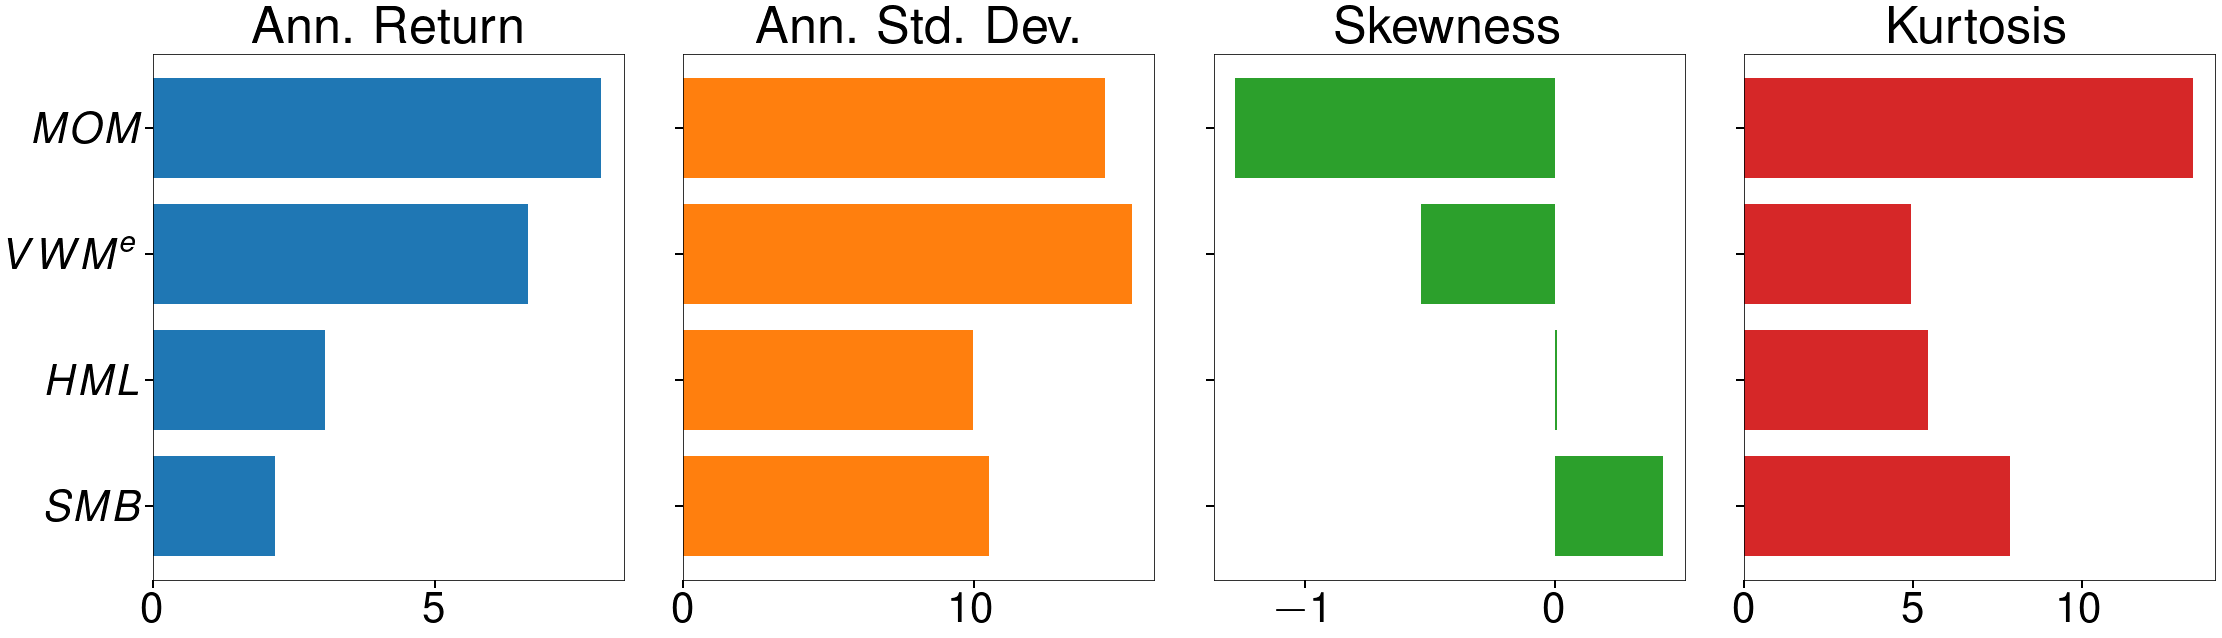

In [3]:
summ_plot(factors)

# Fama-French Factors
## Correlation Structure

In [4]:
factors.corr()

,$VWM^e$,$SMB$,$HML$,$MOM$
$VWM^e$,1.000000,0.300958,-0.226222,-0.149518
$SMB$,0.300958,1.000000,-0.174962,-0.024014
$HML$,-0.226222,-0.174962,1.000000,-0.195242
$MOM$,-0.149518,-0.024014,-0.195242,1.000000


# Size and Value components

In [5]:
figsize()

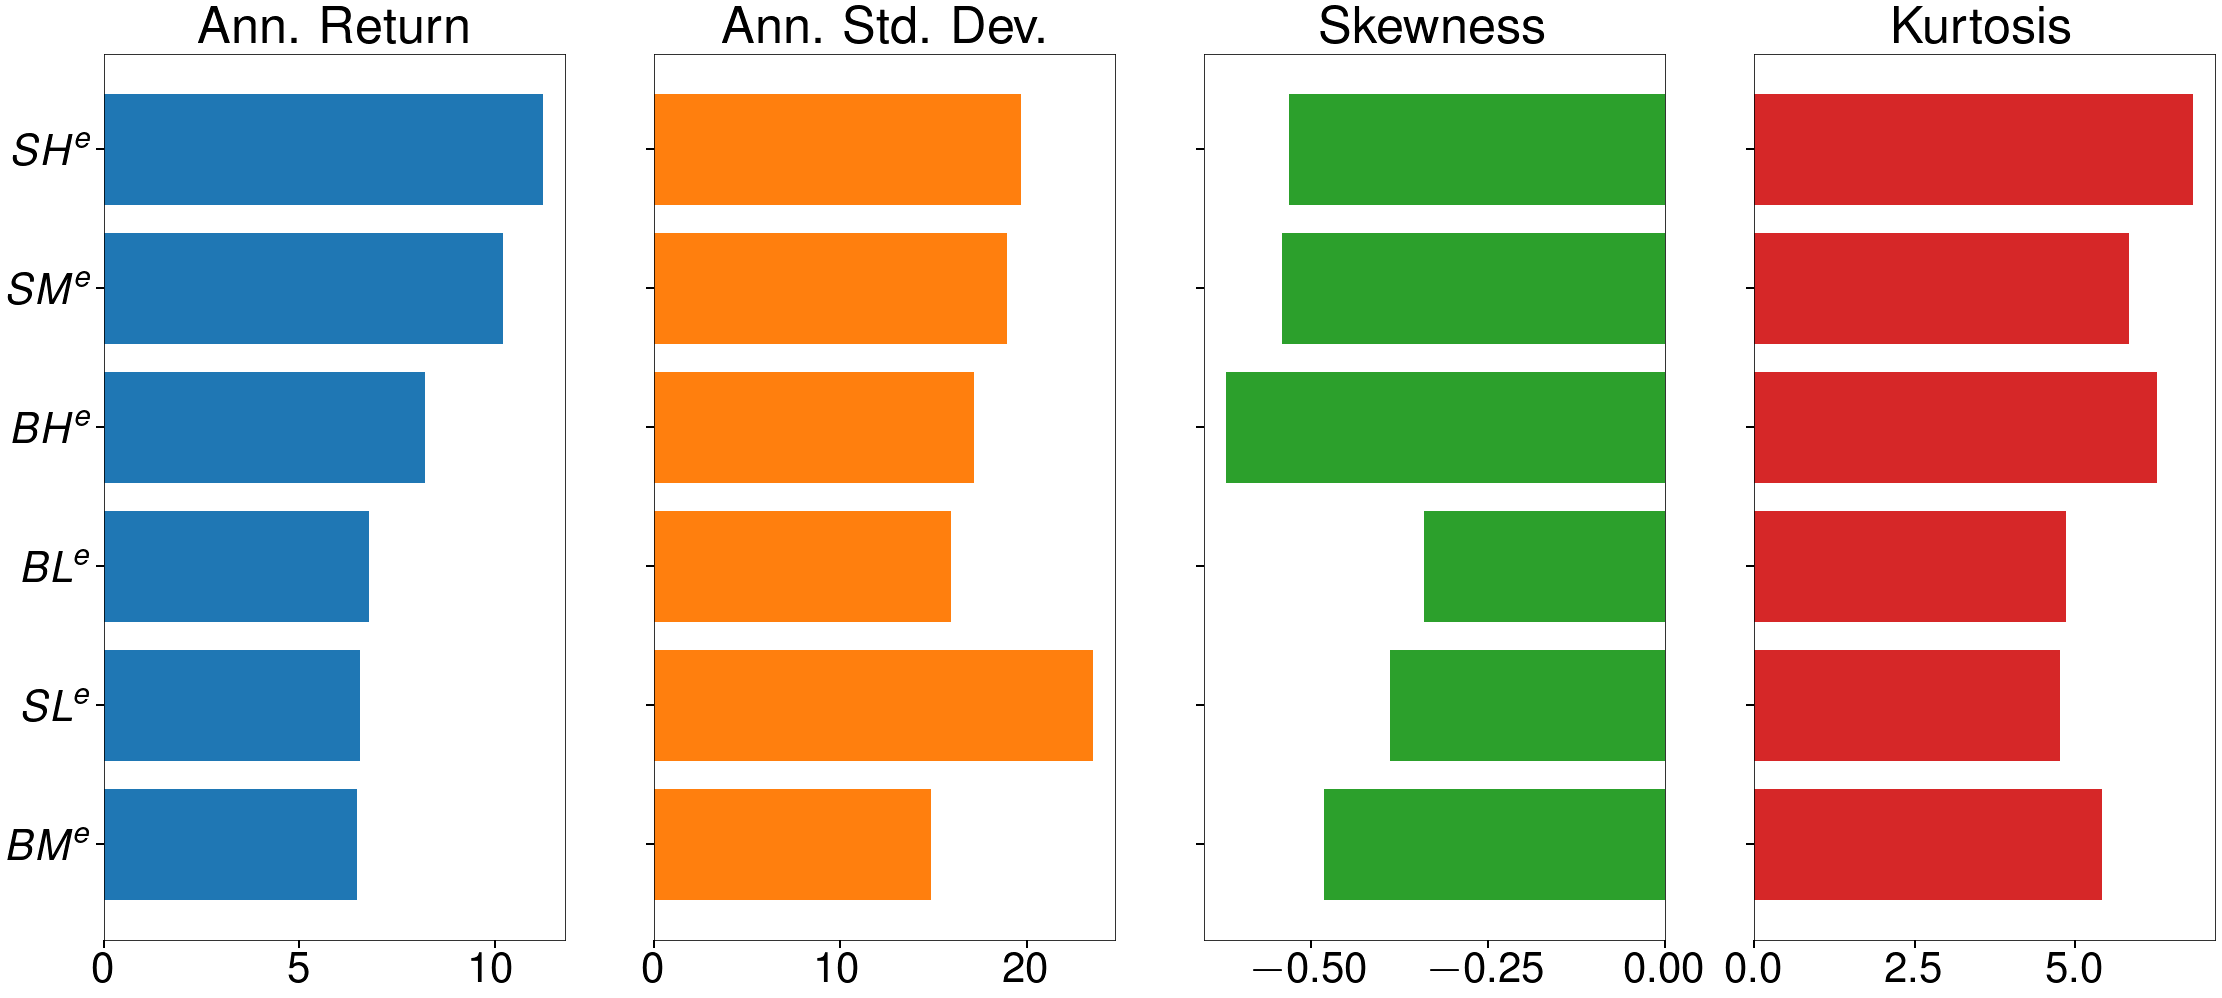

In [6]:
summ_plot(components)

# Industry Portfolios

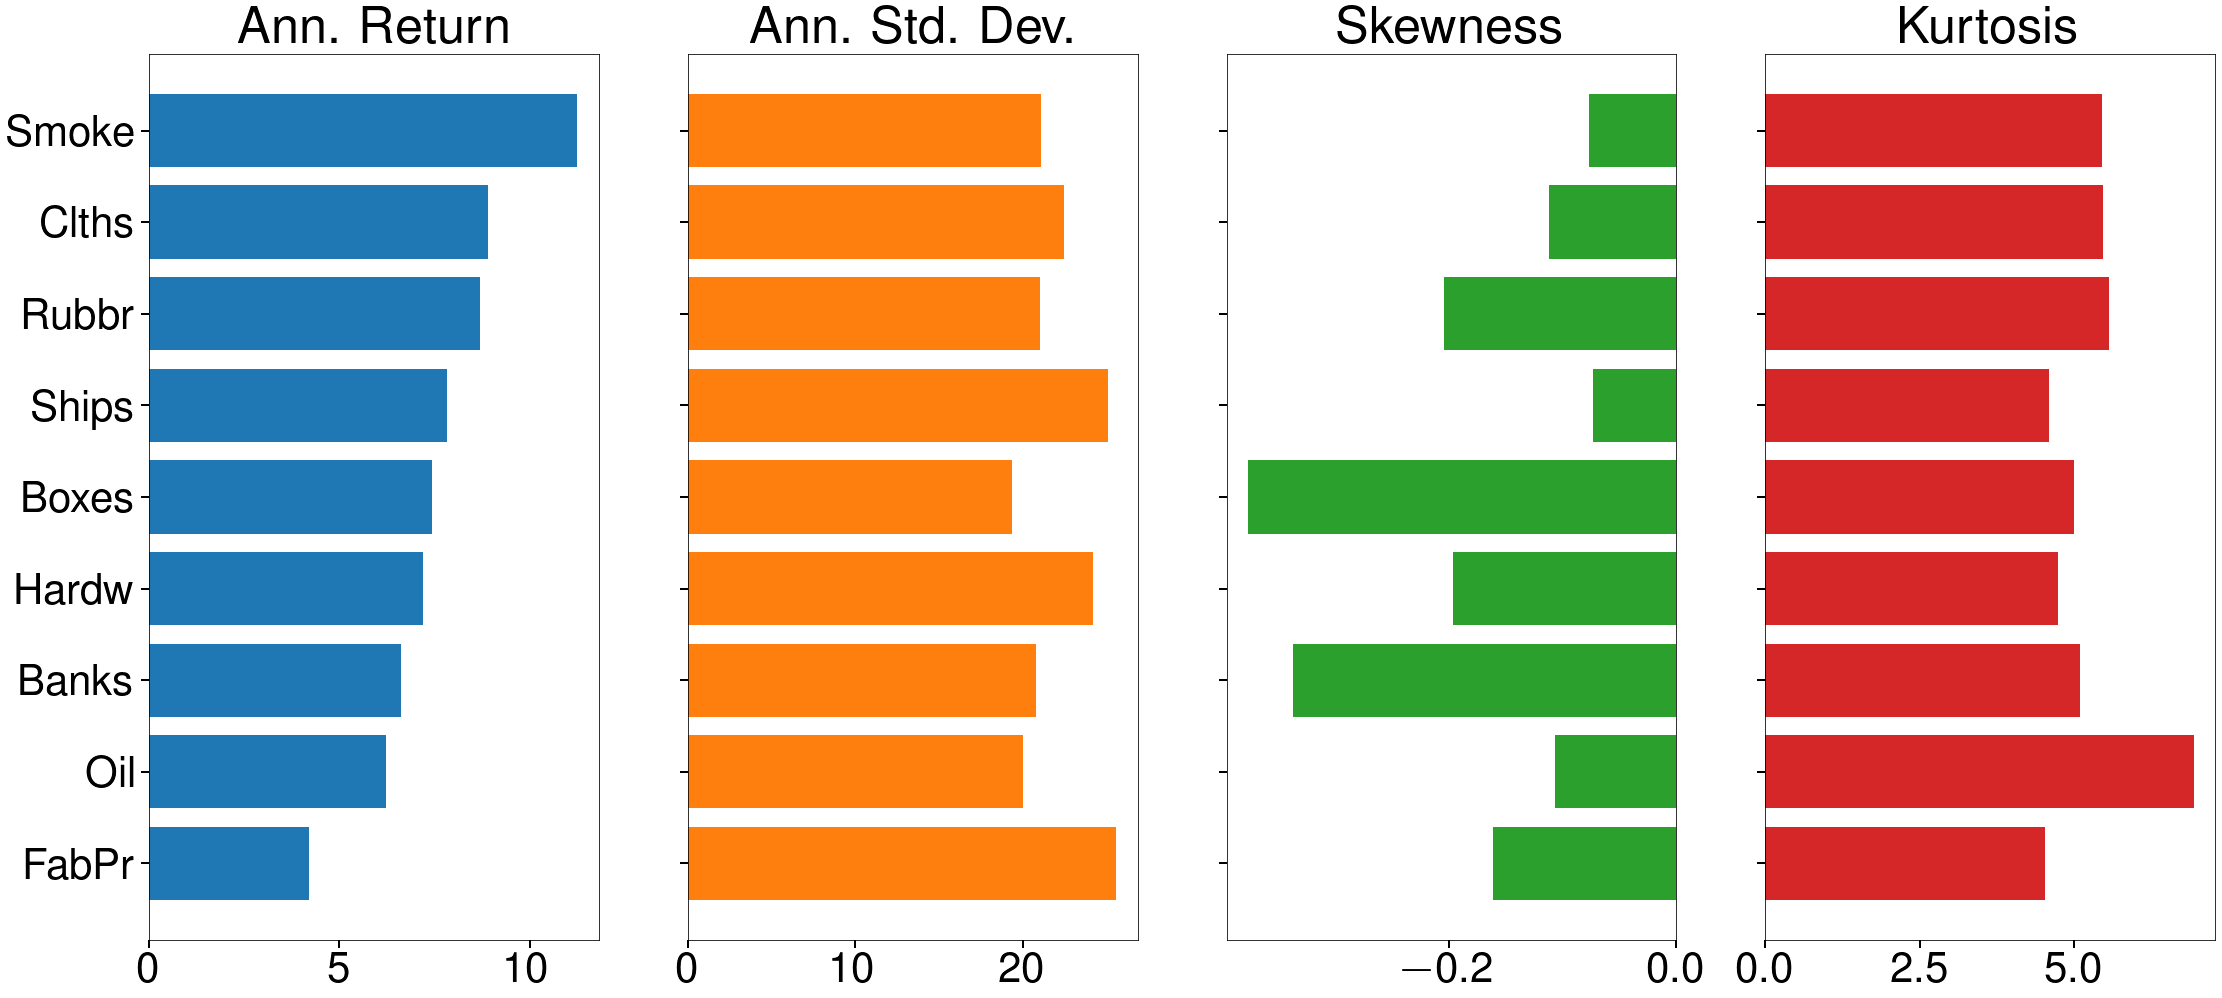

In [7]:
summ_plot(subset)

# Variable Transformations

* Dummy variables
    * 0-1 variables based on an indicator function
$$ I_{[X_{i,j} > 0]} $$
        * Asymmetries at 0
        * Monthly Effects


In [8]:
from datetime import datetime

months_idx = [datetime(2020, i, 1).strftime("%b") for i in range(1, 13)]
months_idx
months = pd.Series(factors.index.month, dtype="category")
months = months.cat.rename_categories(months_idx)
monthly_dummies = pd.get_dummies(months)


def highlight(s):
    is_max = (s == s.max()) & (s != 0)
    return ["background-color:#A4D8A4;color:#004400" if v else "" for v in is_max]

In [9]:
monthly_dummies.head(8)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0


# Variable Transformation: Interactions

* Interactions dramatically expand the functional forms that can be specified
    * Powers and Cross-products: $ X_{i,j}^2 $, $X_{i,j}X_{i,m}$
    * Dummy Interactions to Produce Asymmetries: $ X_{i,j} \times I_{[X_{i,j}<0]} $

In [10]:
interactions = pd.concat(
    [
        (factors["$VWM^e$"] < 0).astype(int),
        factors["$VWM^e$"] * (factors["$VWM^e$"] < 0),
        factors["$VWM^e$"] ** 2,
    ],
    1,
)
interactions.columns = ["Market Negative", "Negative Return", "Squared Returns"]

In [11]:
interactions.tail(10)

,Market Negative,Negative Return,Squared Returns
2019-11-30,0,0.00,14.9769
2019-12-31,0,0.00,7.6729
2020-01-31,1,-0.11,0.0121
2020-02-29,1,-8.13,66.0969
2020-03-31,1,-13.38,179.0244
2020-04-30,0,0.00,186.3225
2020-05-31,0,0.00,31.1364
2020-06-30,0,0.00,6.0516
2020-07-31,0,0.00,33.2929
2020-08-31,0,0.00,58.0644


# Analysis of Cross-Sectional Data

## Parameter Estimation and Model Fit

* Parameter Estimation
* Models with Interactions
* Other estimated quantities
* Regression Coefficient in Factor Models

In [12]:
def summary(res, idx=(1,)):
    from IPython.display import display, HTML

    summ = res.summary()
    for i in idx:
        html = summ.tables[i]._repr_html_()
        if i == 0:
            html = html.split("</tr>")
            html = "</tr>".join(html[:-8] + html[-1:])
            html = html.replace("<caption>OLS Regression Results</caption>","")
        display(HTML(html))


def show_params(*args, columns=None):
    params = []
    for arg in args:
        params.append(arg.params)
    params = pd.concat(params, 1)
    if columns:
        params.columns = columns
    return params

# Parameter Estimation

## Least Squares

$$\textrm{argmin}_{\beta}\sum_{i=1}^{n}(Y_{i}-\mathbf{x}_{i}\boldsymbol{\beta})^{2}$$


In [13]:
ls = smf.ols("BHe ~ 1 + VWMe + SMB + HML + MOM", data).fit(cov_type="HC0")
summary(ls)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0859,0.043,-1.991,0.046,-0.170,-0.001
VWMe,1.0798,0.012,93.514,0.000,1.057,1.102
SMB,0.0019,0.017,0.110,0.912,-0.032,0.036
HML,0.7643,0.021,36.380,0.000,0.723,0.805
MOM,-0.0354,0.013,-2.631,0.009,-0.062,-0.009


# Parameter Estimation

## Least Absolute Deviations

$$\textrm{argmin}_{\beta} \sum_{i=1}^{n}|Y_{i}-\mathbf{x}_{i}\boldsymbol{\beta}|$$

In [14]:
lad = smf.quantreg("BHe ~ 1 + VWMe + SMB + HML + MOM", data).fit(q=0.5)
summary(lad)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0306,0.044,-0.696,0.487,-0.117,0.056
VWMe,1.0716,0.010,103.257,0.000,1.051,1.092
SMB,0.0161,0.015,1.090,0.276,-0.013,0.045
HML,0.7503,0.016,47.702,0.000,0.719,0.781
MOM,-0.0272,0.011,-2.581,0.010,-0.048,-0.007


# Estimating Models with Interactions

Added an asymmetry and a square of $VWM$ to the 4-factor model

$$ Util_i =\beta_1 + \beta_2 VWM_i^e + \beta_3 \left(VWM_i^e\right)^2 + \beta_4 VWM_i^e I_{[VWM_i^e < 0]} + \beta_5 SMB_i + \beta_6 HML_i + \beta_7 MOM_i +\epsilon_i $$

In [15]:
model = f"Util ~ 1 + VWMe + I(VWMe**2) + I(VWMe * (VWMe < 0)) + SMB + HML + MOM"
ls_interact = smf.ols(model, data).fit(cov_type="HC0")
summary(ls_interact)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.2857,0.225,1.268,0.205,-0.156,0.727
VWMe,0.4594,0.089,5.154,0.000,0.285,0.634
I(VWMe ** 2),0.0159,0.007,2.240,0.025,0.002,0.030
I(VWMe * (VWMe < 0)),0.3524,0.188,1.870,0.061,-0.017,0.722
SMB,-0.1972,0.048,-4.087,0.000,-0.292,-0.103
HML,0.3470,0.060,5.810,0.000,0.230,0.464
MOM,0.0611,0.039,1.578,0.114,-0.015,0.137


In [16]:
ls_no_interact = smf.ols(f"Util ~ 1 + VWMe + SMB + HML + MOM", data).fit(cov_type="HC0")

plt.rc("figure", figsize=(32, 12))


def plot_market_interactions():
    v = data.VWMe.to_numpy()
    b = 1.1 * max(abs(data.VWMe.min()), data.VWMe.max())
    projected_x = np.linspace(-b, b, 201)
    _x = np.c_[
        np.ones_like(projected_x),
        projected_x,
        projected_x ** 2,
        projected_x * (projected_x < 0),
    ]
    fitted_line = _x @ ls_interact.params.iloc[:4]
    fitted = (
        np.c_[np.ones_like(v), v, v ** 2, v * (v < 0)] @ ls_interact.params.iloc[:4]
    )
    fig, ax = plt.subplots(1, 1)
    ax.plot(
        projected_x,
        fitted_line,
        projected_x,
        projected_x * ls_no_interact.params.iloc[1] + ls_no_interact.params.iloc[0],
    )
    ax.set_xlim(-b, b)
    ax.legend(["With Interactions", "No Interactions"], frameon=False)
    ax.scatter(v, fitted, color=mfe.colors[0], marker="x", s=400)
    ax.scatter(
        v, data.Util, color=mfe.colors[2], marker="o", s=200, zorder=-4, alpha=0.5
    )
    fig.tight_layout(pad=1.0)
    return None

# Expected and Fitted Values
* Fitted values:

$$ \hat{Y}_i = \mathbf{x}_i \hat{\boldsymbol{\beta}} $$

* Expected values:

$$ E[Y|X=\mathbf{x}] = \mathbf{x} \hat{\boldsymbol{\beta}} $$

In [17]:
figsize()

# Expected and Fitted Values

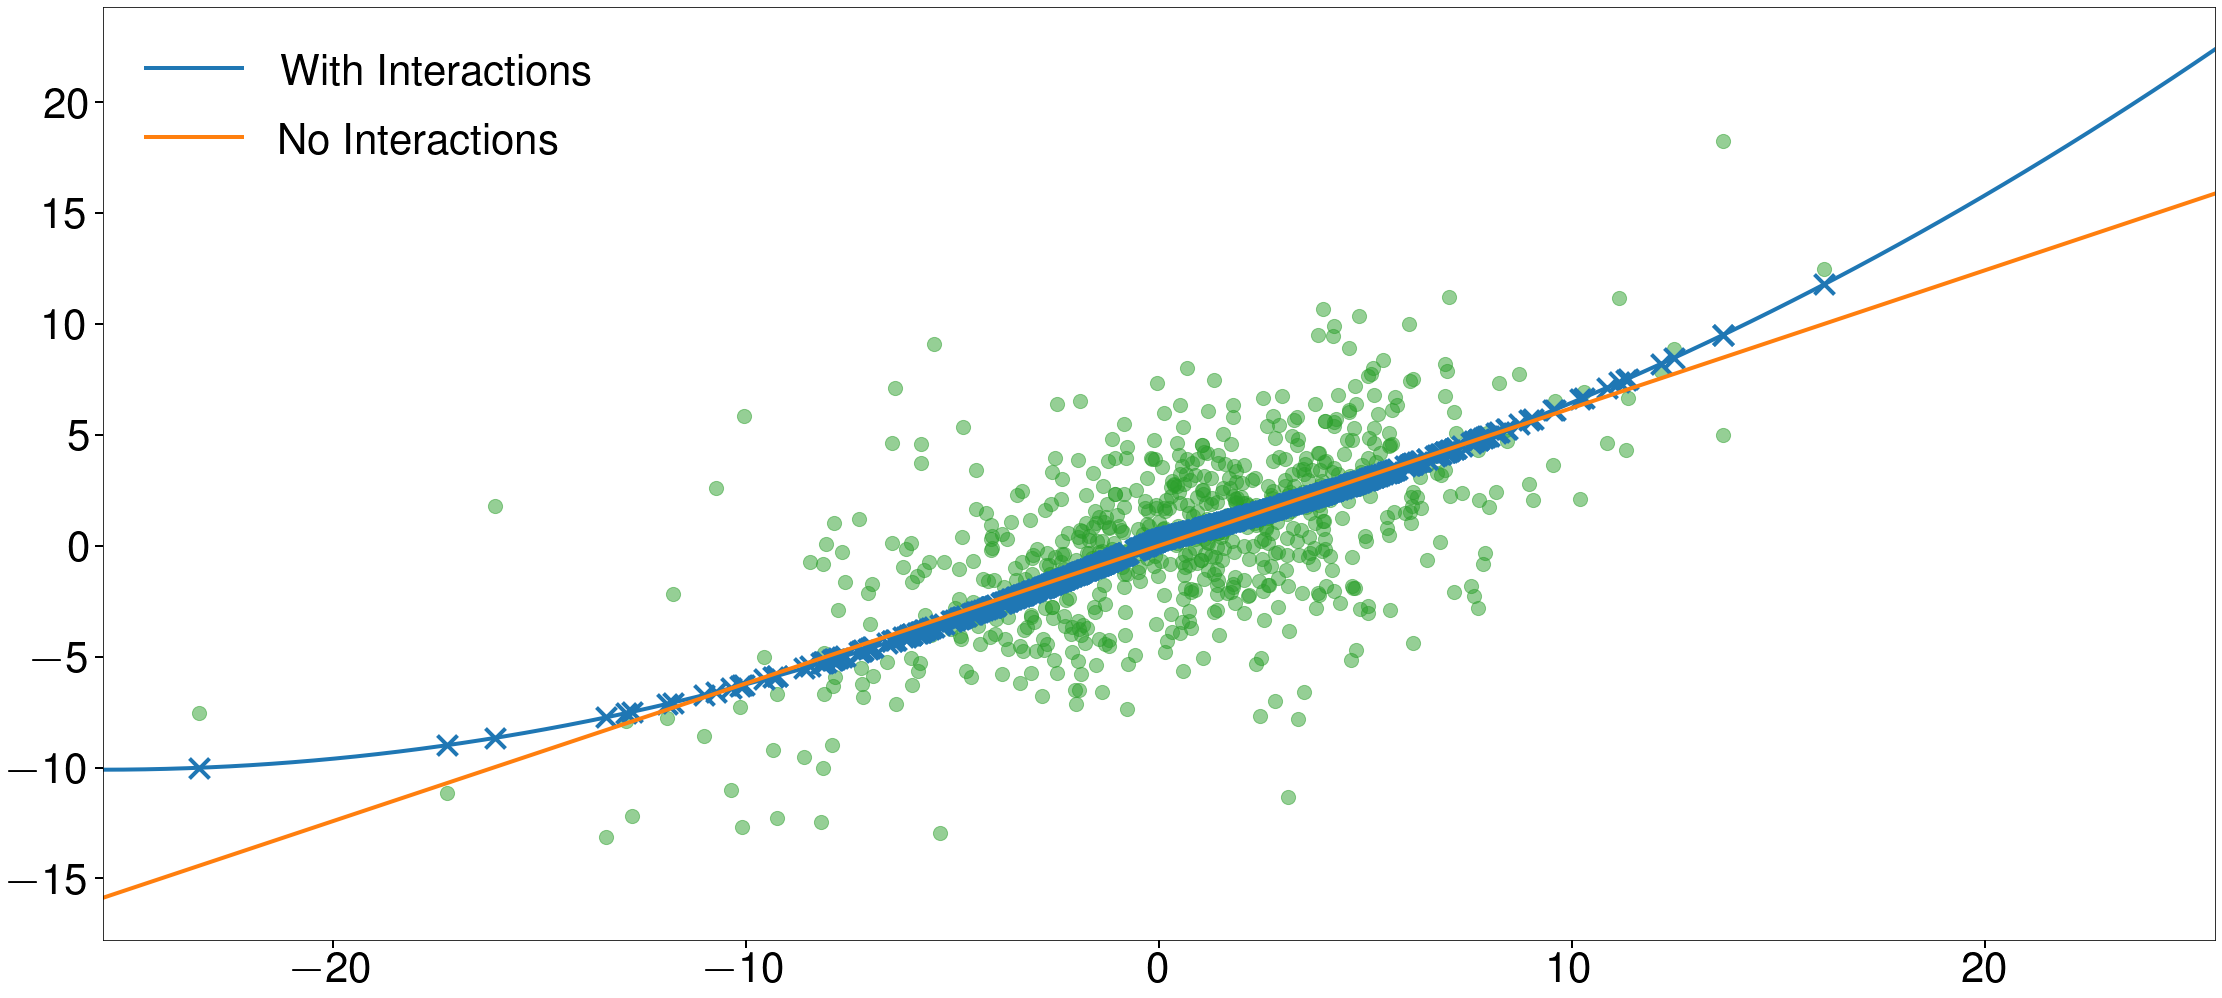

In [18]:
plot_market_interactions()

In [19]:
figsize()


def beta_plot(df, titles=None):
    idx = np.arange(df.shape[0])
    k = df.shape[1]
    fig, ax = plt.subplots(1, k)
    n = len(idx)
    for i in range(k):
        ax[i].barh(np.arange(n), df.iloc[:, i], align="center", color=mfe.colors[i])
        ax[i].set_yticks(np.arange(n))
        if i == 0:
            ax[i].set_yticklabels(df.index)
        else:
            ax[i].set_yticklabels([])
        if titles:
            ax[i].set_title(titles[i])

    fig.tight_layout(pad=1.0)


_x = ls.model.data.orig_exog
betas = []
for col in components:
    betas.append(sm.OLS(components[col], _x).fit().params)
betas = pd.concat(betas, 1)
betas.columns = components.columns
betas = betas.T.iloc[:, 1:]
titles = list(factors.columns)
figsize(y=12)

# Typical Regression Coefficients

## Factor Components

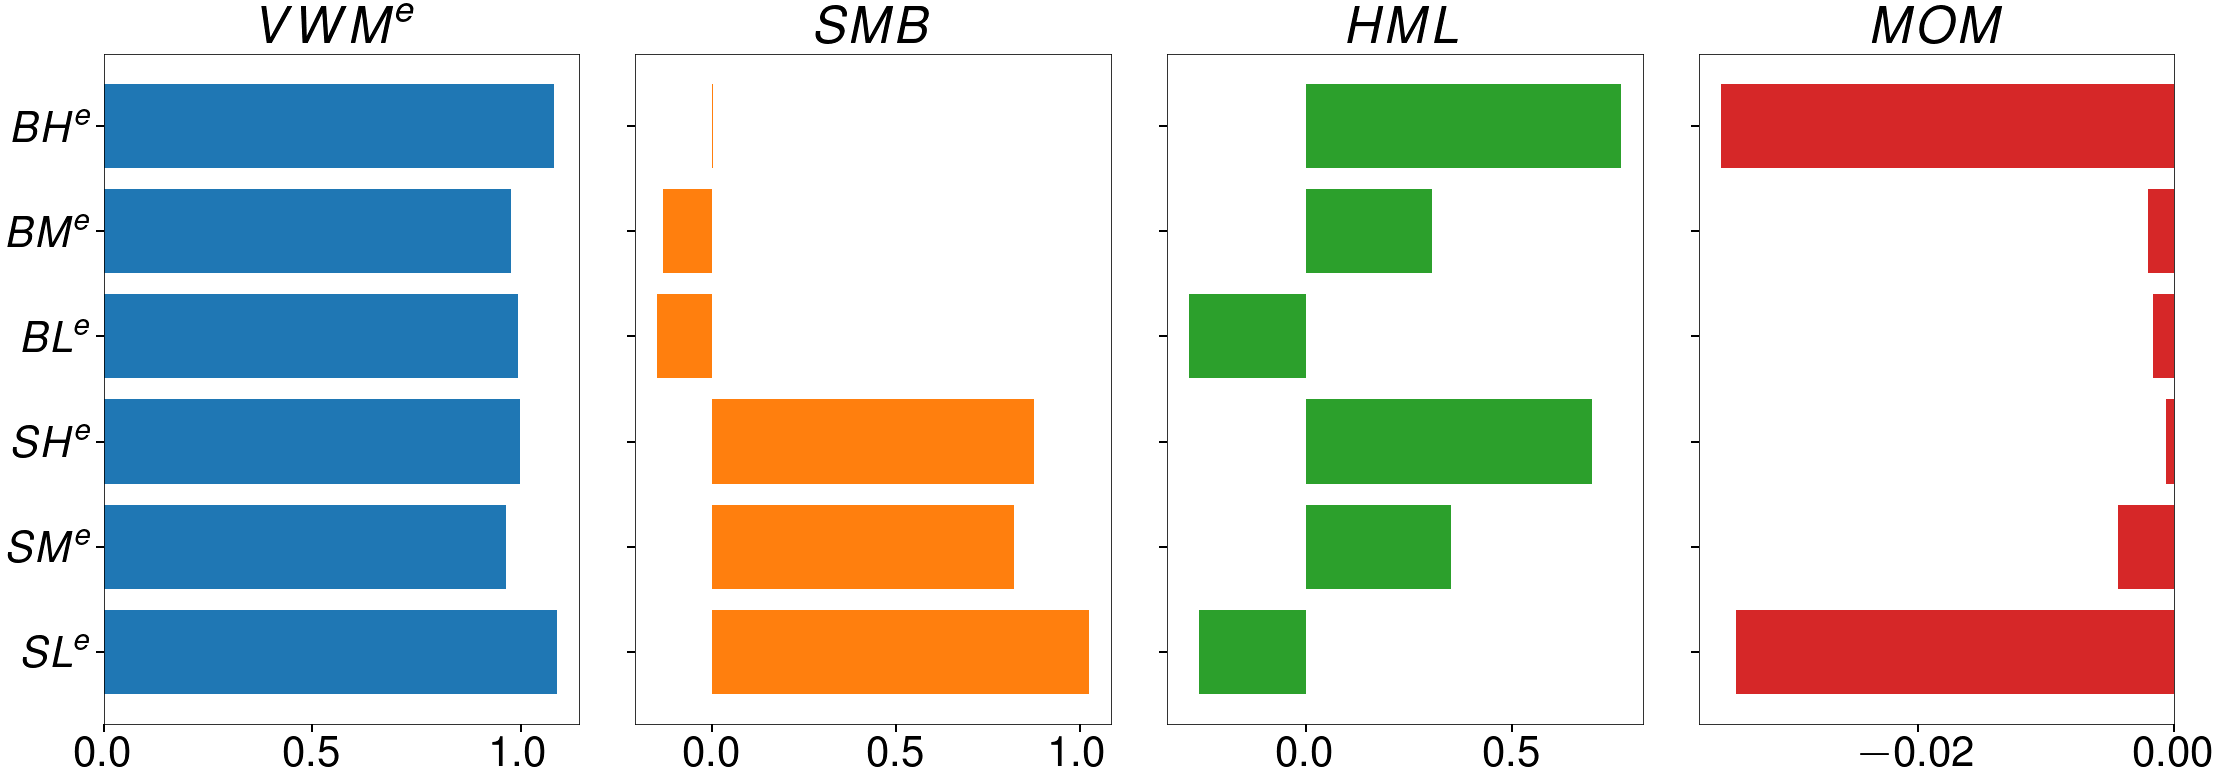

In [20]:
beta_plot(betas, titles)

In [21]:
def beta_plot(df, titles=None):
    idx = np.arange(df.shape[0])
    k = df.shape[1]
    fig, ax = plt.subplots(1, k)
    n = len(idx)
    for i in range(k):
        ax[i].barh(np.arange(n), df.iloc[:, i], align="center", color=mfe.colors[i])
        ax[i].set_yticks(np.arange(n))
        if i == 0:
            ax[i].set_yticklabels(df.index)
        else:
            ax[i].set_yticklabels([])
        if titles:
            ax[i].set_title(titles[i])

    fig.tight_layout(pad=1.0)


_x = ls.model.data.orig_exog
betas = []
for col in subset:
    betas.append(sm.OLS(industries[col], _x).fit().params)
betas = pd.concat(betas, 1)
betas.columns = subset.columns
betas = betas.T.iloc[:, 1:]
titles = list(factors.columns)
figsize(y=12)

# Typical Regression Coefficients

## Industry Portfolios

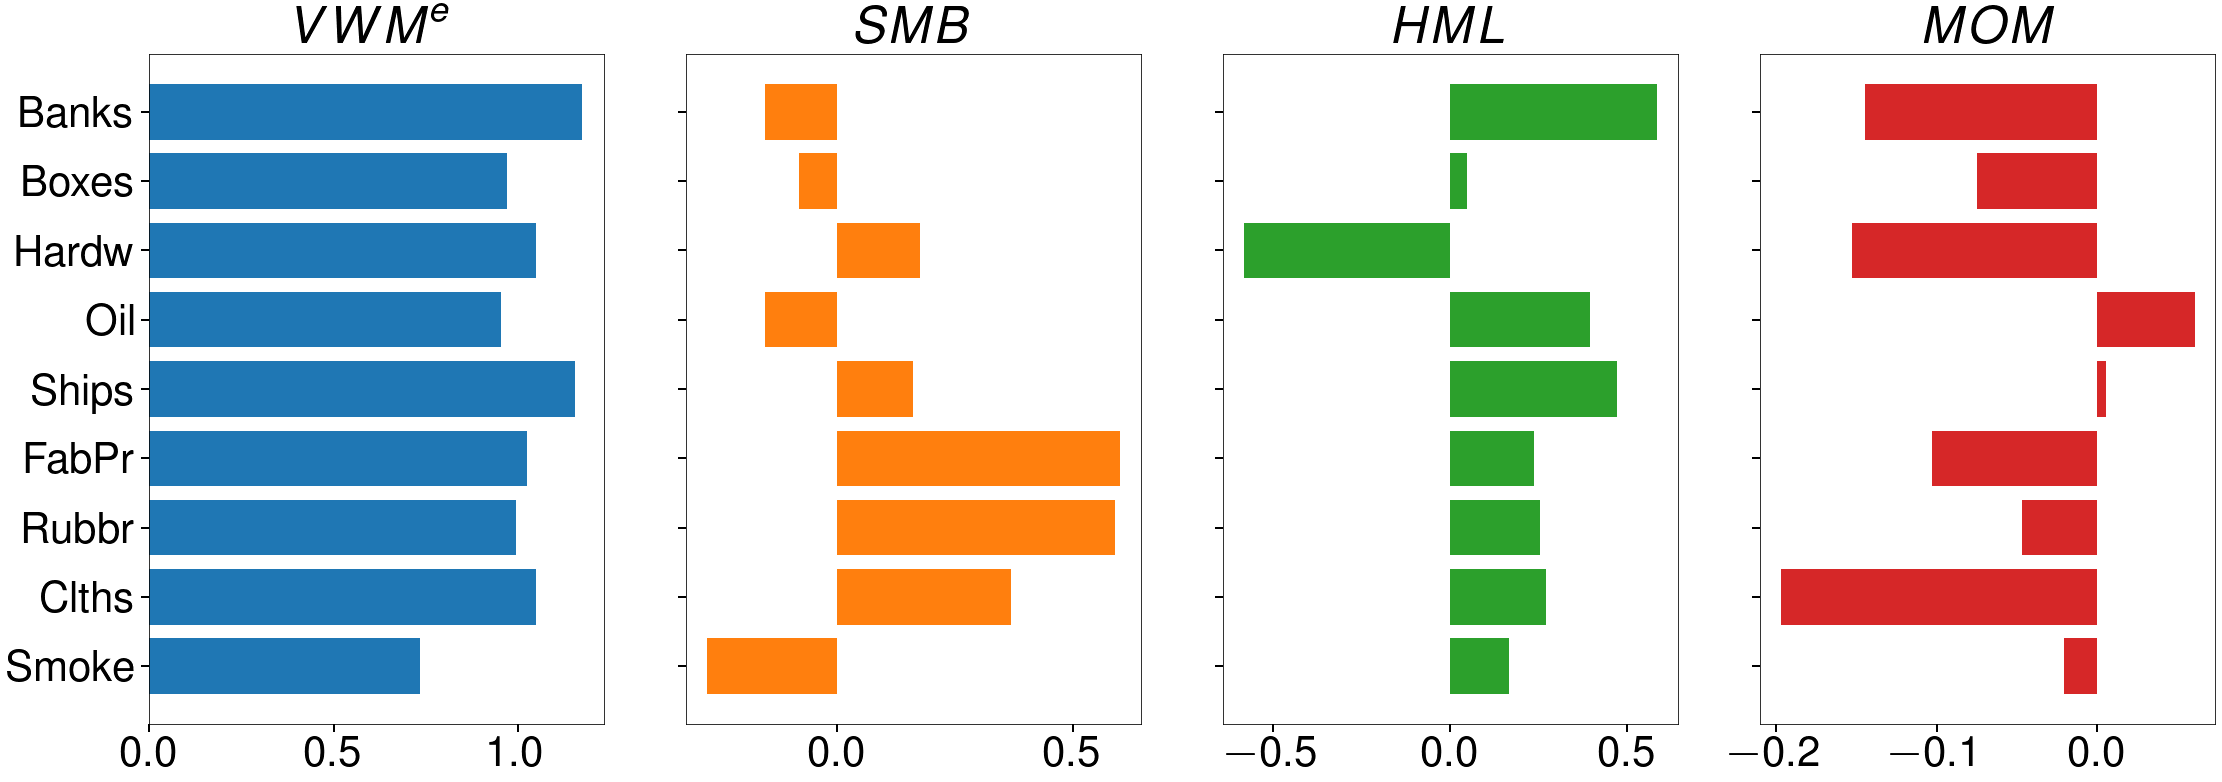

In [22]:
beta_plot(betas, titles)

In [23]:
_x = ls_interact.model.data.orig_exog
betas = []
for col in subset:
    betas.append(sm.OLS(industries[col], _x).fit().params)
betas = pd.concat(betas, 1)
betas.columns = subset.columns
betas = betas.T.iloc[:, 1:4]
titles = r"$VWM^e$,${VWM^e}^2$,$VWM^e \times I_{VWM^e<0}$".split(",")

# Evidence of Non-linear returns

* Add square and asymmetry to 4-factor model

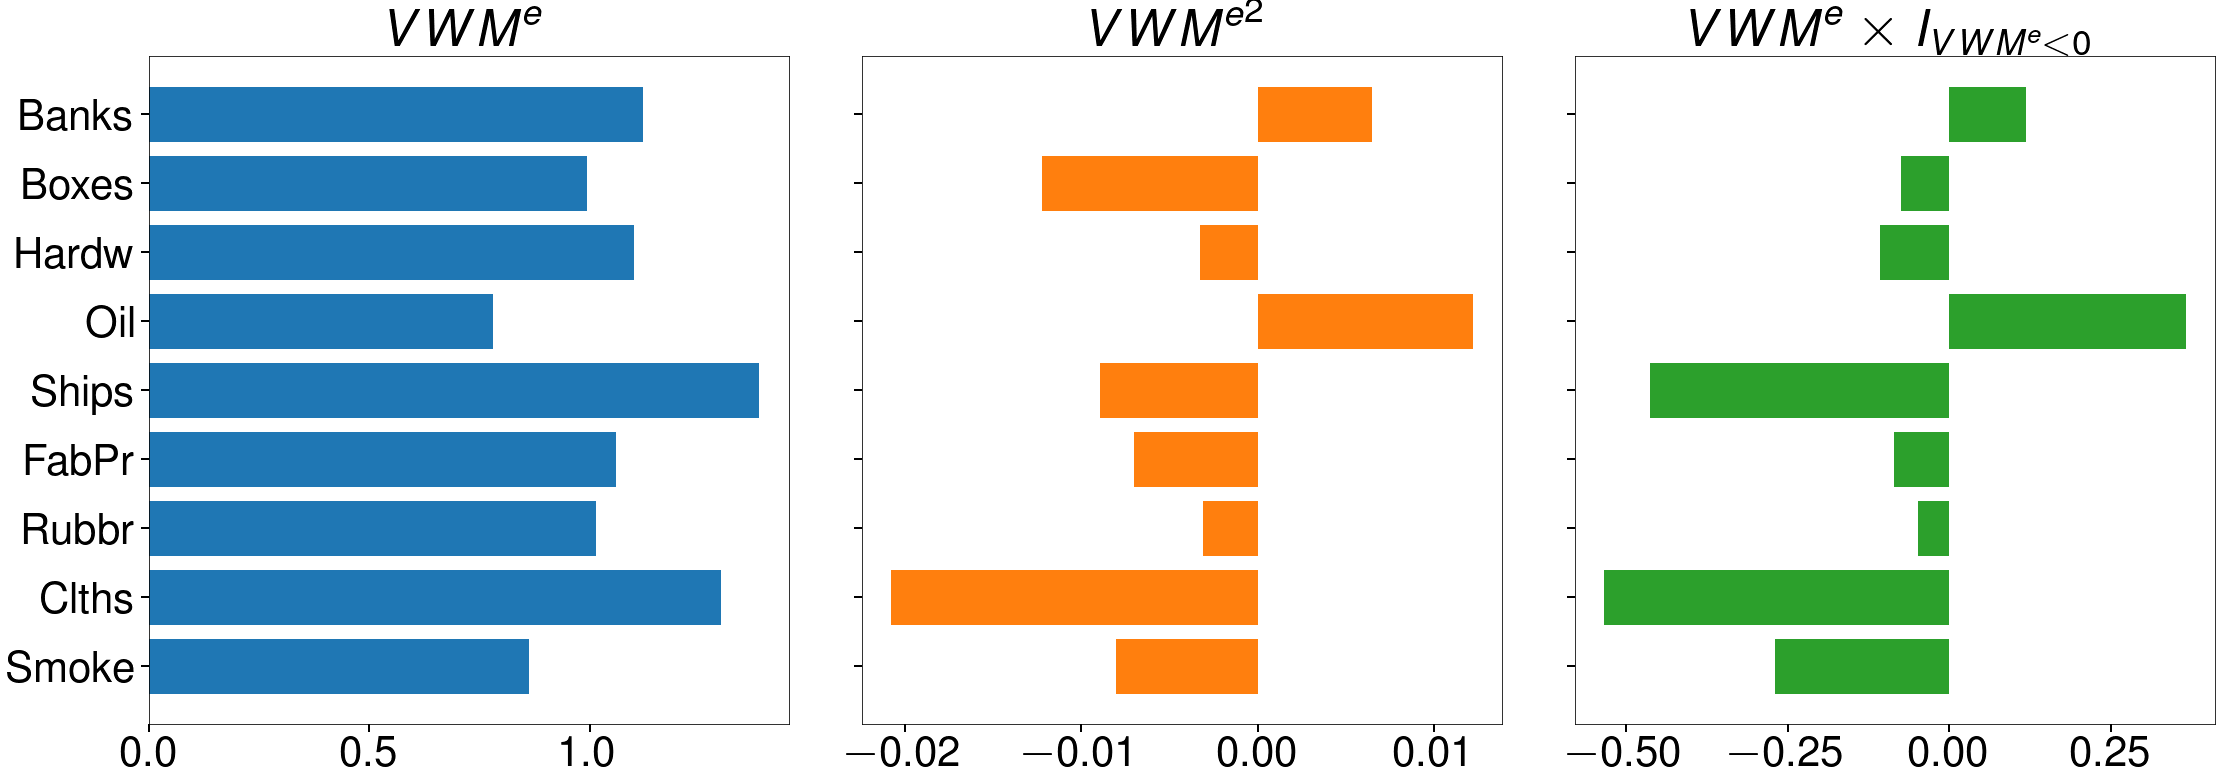

In [24]:
beta_plot(betas, titles)

# Measuring fit
* Coefficient of Determination
$$ R^2 = 1-  \frac{SSE}{TSS} = \frac{RSS}{TSS}$$
* Based on a complete decomposition $ TSS = SSE + RSS $
* Total Sum of Squares
$$ TSS = \sum_{i=1}^n (Y_i - \bar{Y})^2$$
* Sum of Squared Errors
$$SSE = \sum_{i=1}^n \hat{\epsilon}_i^2$$
* Regression Sum of Squares
$$ RSS = \sum_{i=1}^n (\hat{Y}_i - \bar{Y})^2  = \sum_{i=1}^n (\mathbf{x}_i\hat{\boldsymbol{\beta}}- \bar{Y})^2$$


# Measuring Fit

In [25]:
ls = smf.ols("BHe ~ 1 + VWMe + SMB + HML + MOM", data).fit(cov_type="HC0")
summary(ls, [0])

Dep. Variable:,BHe,R-squared:,0.954
Model:,OLS,Adj. R-squared:,0.954


# Measuring Fit
## Component and Industry Fits

In [26]:
df = pd.concat([components, subset], axis=1)
x = ls.model.data.orig_exog
r2 = {}
for col in df:
    r2[col] = sm.OLS(df[col], x).fit().rsquared
r2 = 100 * pd.Series(r2, name="$R^2$")


def r2_plot():
    idx = r2.index
    fig, ax = plt.subplots(1, 1)
    n = len(idx)
    colors = [mfe.colors[1] if i < 6 else mfe.colors[3] for i in range(n)]
    ax.barh(np.arange(n), r2, align="center", color=colors)
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(r2.index)
    title = "$R^2$ (\%)"
    ax.set_title(title)
    fig.tight_layout(pad=1.0)

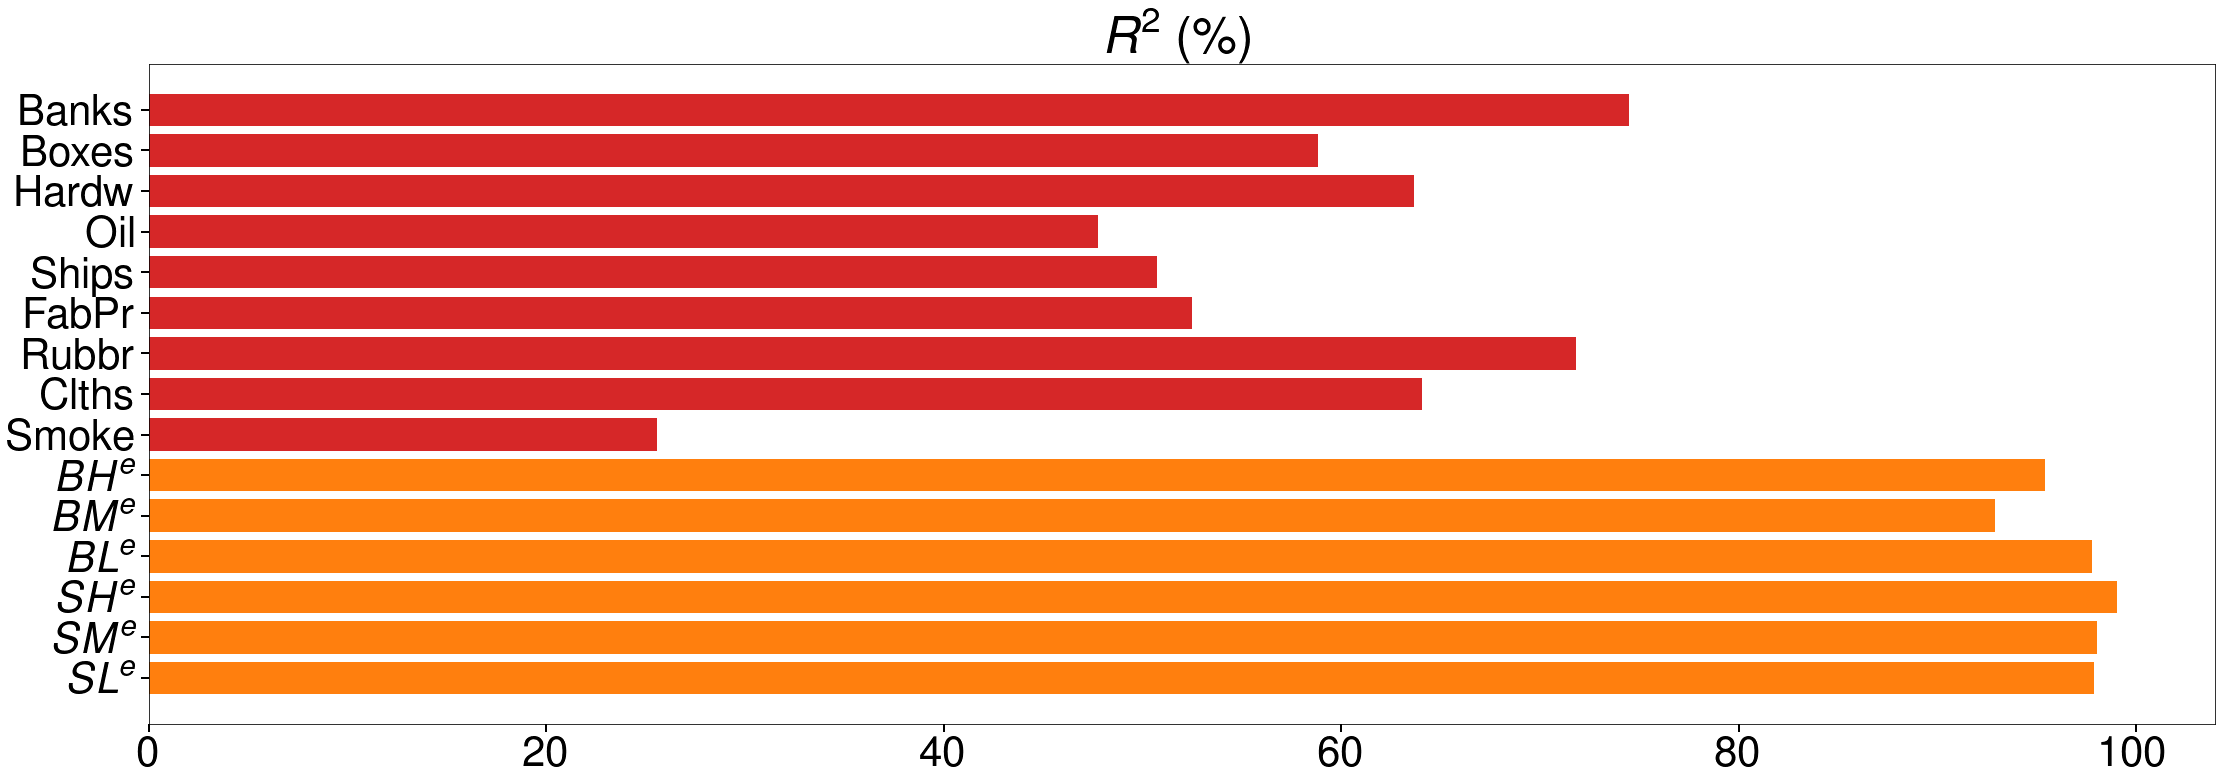

In [27]:
r2_plot()

# Measuring Fit
## Shifting variables
$$ BH_i^e + 99 = \beta_1 + \beta_2 VWM_i^e + \beta_3 SMB_i + \beta_4 HML_i + \beta_5 MOM_i + \epsilon_i$$

In [28]:
shifted_mod = "I(BHe + 99) ~ 1 + VWMe + SMB + HML + MOM"
ls_shift = smf.ols(shifted_mod, data).fit(cov_type="HC0")
summary(ls_shift, [0])

Dep. Variable:,I(BHe + 99),R-squared:,0.954
Model:,OLS,Adj. R-squared:,0.954


In [29]:
summary(ls, [0])

Dep. Variable:,BHe,R-squared:,0.954
Model:,OLS,Adj. R-squared:,0.954


# Measuring Fit
## Rescaling variables

$$ \pi BH_i^e = \beta_1 + \beta_2 VWM_i^e + \beta_3 SMB_i + \beta_4 HML_i + \beta_5 MOM_i + \epsilon_i$$


In [30]:
rescaled_mod ="I(np.pi * BHe) ~ 1 + VWMe + SMB + HML + MOM"
ls_scale = smf.ols(rescaled_mod, data).fit(cov_type="HC0")
summary(ls_scale, [0])

Dep. Variable:,I(np.pi * BHe),R-squared:,0.954
Model:,OLS,Adj. R-squared:,0.954


In [31]:
summary(ls, [0])

Dep. Variable:,BHe,R-squared:,0.954
Model:,OLS,Adj. R-squared:,0.954



# Measuring Fit
## Changing the LHS Variable

$$ (BH_i^e - VWM^e_i - HML_i) = \beta_1 + \beta_2 VWM_i^e + \beta_3 SMB_i + \beta_4 HML_i + \beta_5 MOM_i + \epsilon_i$$


In [32]:
model = "I(BHe - VWMe - HML) ~ 1 + VWMe + SMB + HML + MOM"
ls_lhs = smf.ols(model, data).fit(cov_type="HC0")
summary(ls_lhs, [0])

Dep. Variable:,I(BHe - VWMe - HML),R-squared:,0.382
Model:,OLS,Adj. R-squared:,0.378


In [33]:
summary(ls, [0])

Dep. Variable:,BHe,R-squared:,0.954
Model:,OLS,Adj. R-squared:,0.954


# Measuring fit
## Caveats when model excludes the constant

$$ BH_i^e + 99 = \beta_1 VWM_i^e + \beta_2 SMB_i + \beta_3 HML_i + \beta_4 MOM_i + \epsilon_i$$


In [34]:
ls_p99 = smf.ols("I(BHe + 99) ~ VWMe + SMB + HML + MOM - 1", data).fit(cov_type="HC0")
summary(ls_lhs, [0, 1])

Dep. Variable:,I(BHe - VWMe - HML),R-squared:,0.382
Model:,OLS,Adj. R-squared:,0.378


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0859,0.043,-1.991,0.046,-0.170,-0.001
VWMe,0.0798,0.012,6.910,0.000,0.057,0.102
SMB,0.0019,0.017,0.110,0.912,-0.032,0.036
HML,-0.2357,0.021,-11.219,0.000,-0.277,-0.195
MOM,-0.0354,0.013,-2.631,0.009,-0.062,-0.009


# Estimating the residual variance

## Small-sample corrected estimator

* Variance of shock estimated using model residuals

$$ s^2 = \frac{1}{n-k}\sum_{i=1}^n \hat{\epsilon}_i^2 = \frac {\hat{\boldsymbol{\epsilon}}^\prime\hat{\boldsymbol{\epsilon}}}{n-k}$$

In [35]:
x = ls.model.data.orig_exog
eps = ls.resid
n = eps.shape[0]
k = x.shape[1]

In [36]:
s2 = eps.T @ eps / (n - k)
pretty(f"{s2:0.3f}")

# Estimating the residual variance

## Large-sample estimator

* Asymptotic results usually use the large-sample version of the variance estimator

$$ \hat{\sigma}^2 = \frac{1}{n}\sum_{i=1}^n \hat{\epsilon}_i^2 = \frac {\hat{\boldsymbol{\epsilon}}^\prime\hat{\boldsymbol{\epsilon}}}{n} $$

In [37]:
sigma2 = eps.T @ eps / n
pretty(f"{sigma2:0.3f}")

# Scores and the first-order condition of OLS

* The FOC of a regression is
$$ \mathbf{X}^\prime \hat{\boldsymbol{\epsilon}} = \sum_{i=1}^n \mathbf{x}^\prime_i \hat{\epsilon}_i = \mathbf{0} $$
* Estimated residuals are _always_ orthogonal with included regressors
* Later we will see these can be used to test models if $\approx \mathbf{0}$

In [38]:
x = ls.model.data.orig_exog
eps = ls.resid.to_numpy()[:, None]
scores = x.T @ eps
scores.columns = ["Scores"]

In [39]:
scores

,Scores
Intercept,6.605827e-13
VWMe,1.290656e-11
SMB,5.131937e-13
HML,2.596146e-12
MOM,-2.812278e-12


# Analysis of Cross-Sectional Data
##  Properties of OLS Estimators

* Invariance  to Affine Transformations
* Asymptotic Distribution 
* Feasible Central Limit Theorems
* Bootstrap Estimation of the Covariance

# Variable Transformations
## Rescaling by a constant

$$ \frac{Y_i}{100} = \beta_1  + \beta_2 \frac{X_{i,2}}{100} + \ldots + \beta_k \frac{X_{i,k}}{100}  + \epsilon_i$$

In [40]:
model = "BHe ~ 1 + VWMe + SMB + HML + MOM"
rescaled_ls = smf.ols(model, data / 100.0).fit(cov_type="HC0")
show_params(rescaled_ls, ls, columns=["Rescaled", "Orig"])

,Rescaled,Orig
Intercept,-0.000859,-0.085899
VWMe,1.079785,1.079785
SMB,0.001894,0.001894
HML,0.764300,0.764300
MOM,-0.035397,-0.035397


# Variable Transformations
## Rescaling single variables

$$ Y_i = \beta_1  + \beta_2 \left(2 VWM^e_i\right) + \beta_3 SMB_i + \beta_4 \frac{HML_i}{2} + \beta_4 MOM_i +  \epsilon_i$$

In [41]:
model = "BHe ~ 1 + I(2 * VWMe) + SMB + I(1/2 * HML) + MOM"
ls_p10 = smf.ols(model, data).fit(cov_type="HC0")
show_params(ls_p10, columns=["Plus 10"])

,Plus 10
Intercept,-0.085899
I(2 * VWMe),0.539893
SMB,0.001894
I(1 / 2 * HML),1.528600
MOM,-0.035397


# Variable Transformations
## Affine Transformations

$$ \left(3 BH^e + 7 \right) = \beta_1  + \beta_2 \left(2 VWM^e_i - 9\right) + \beta_3 \frac{SMB_i}{2} + \beta_4 HML_i + \beta_4 MOM_i +  \epsilon_i$$

In [42]:
model = "I(3 * BHe + 7)  ~ 1 + I(2 * VWMe - 9) + I(1/2 *SMB) + HML + MOM"
ls_affine = smf.ols(model, data).fit(cov_type="HC0")
show_params(ls_affine, columns=["Affine"])

,Affine
Intercept,21.319408
I(2 * VWMe - 9),1.619678
I(1 / 2 * SMB),0.011361
HML,2.292901
MOM,-0.106192


In [43]:
pretty(f"Ratio: {ls_affine.params['I(2 * VWMe - 9)'] / ls.params['VWMe']:0.3f}")

# Characterizing Parameter Estimation Error

* Central Limit Theorem

$$\sqrt{n}\left(\hat{\boldsymbol{\beta}}_n-\boldsymbol{\beta}\right) \stackrel{d}{\rightarrow} N\left(\mathbf{0},\boldsymbol{\Sigma}_{XX}^{-1}\mathbf{S}\boldsymbol{\Sigma}_{XX}^{-1}\right)$$

* Covariance components $\boldsymbol{\Sigma}_{XX} = E\left[\mathbf{x}_i^\prime\mathbf{x}_i\right]$ and $\mathbf{S} = \mathrm{p}-\lim_{n\rightarrow\infty} \mathrm{Var}\left[\sqrt{n}\frac{1}{n}\sum_{i=1}^n\mathbf{x}_i^\prime \epsilon_i\right] $.

* In practice

$$\hat{\boldsymbol{\beta}}_n \stackrel{\approx}{\sim}N\left(\boldsymbol{\beta},\frac{\hat{\boldsymbol{\Sigma}}_{XX}^{-1}\hat{\mathbf{S}}\hat{\boldsymbol{\Sigma}}_{XX}^{-1}}{n}\right) $$


# Characterizing Parameter Estimation Error
## Parameter Covariance Matrix

In [44]:
ls.cov_params()

,Intercept,VWMe,SMB,HML,MOM
Intercept,0.001860,-0.000171,0.000079,-0.000157,-0.000154
VWMe,-0.000171,0.000133,-0.000060,0.000039,0.000019
SMB,0.000079,-0.000060,0.000297,0.000042,0.000019
HML,-0.000157,0.000039,0.000042,0.000441,0.000122
MOM,-0.000154,0.000019,0.000019,0.000122,0.000181


# Characterizing Parameter Estimation Error
## Estimating the Covariance
$$ \hat{\boldsymbol{\Sigma}}_{XX} = \frac{1}{n}\mathbf{X}^\prime\mathbf{X} \text { and } \hat{\mathbf{S}} = \sum_{i=1}^n \hat{\epsilon_i}^2 \mathbf{x}_i^\prime\mathbf{x}_i$$

In [45]:
xe = x * eps
S = xe.T @ xe / n
Sigma_inv = np.linalg.inv(x.T @ x / n)
cov = 1 / n * (Sigma_inv @ S @ Sigma_inv)
cov.index = cov.columns = x.columns
cov

,Intercept,VWMe,SMB,HML,MOM
Intercept,0.001860,-0.000171,0.000079,-0.000157,-0.000154
VWMe,-0.000171,0.000133,-0.000060,0.000039,0.000019
SMB,0.000079,-0.000060,0.000297,0.000042,0.000019
HML,-0.000157,0.000039,0.000042,0.000441,0.000122
MOM,-0.000154,0.000019,0.000019,0.000122,0.000181


# Characterizing Parameter Estimation Error
## Standard Errors
* Root of diagonal elements of VCV

In [46]:
pretty(ls.bse)

,
Intercept,0.043134
VWMe,0.011547
SMB,0.017224
HML,0.021009
MOM,0.013455


# Bootstrapping the Covariance

* Simulate from data to estimate covariance
* Randomly sample $n$ observation with replacement $\left(y_i,\mathbf{x}_i\right)$
* Estimate $\hat{\beta}_b$ from random sample
* Repeat $B$ times
* Compute covariance from bootstrapped $\hat{\beta}_b$

In [47]:
betas = []
g = np.random.default_rng(2020)
lhs = ls.model.data.orig_endog
for i in range(1000):
    idx = g.integers(n, size=n)
    xb = x.iloc[idx]
    yb = lhs.iloc[idx]
    beta = sm.OLS(yb, xb).fit().params
    betas.append(beta)
betas = pd.DataFrame(betas, columns=x.columns, index=np.arange(1, len(betas) + 1))
betas.index.name = "b"

# Boootstrap $\beta$ estimates


In [48]:
betas.head()

,Intercept,VWMe,SMB,HML,MOM
b,,,,,
1,-0.032329,1.073407,-0.002263,0.747751,-0.059899
2,-0.098095,1.082409,0.047483,0.750626,-0.023940
3,-0.037763,1.085002,0.036935,0.776792,-0.025469
4,-0.019000,1.083847,-0.002470,0.689036,-0.053007
5,-0.052940,1.067186,0.032972,0.783204,-0.034621


# Comparing the Bootstrap and the Traditional Estimator

In [49]:
betas.cov()

,Intercept,VWMe,SMB,HML,MOM
Intercept,0.001868,-0.000182,0.000124,-0.000100,-0.000134
VWMe,-0.000182,0.000135,-0.000062,0.000035,0.000015
SMB,0.000124,-0.000062,0.000313,0.000033,0.000018
HML,-0.000100,0.000035,0.000033,0.000405,0.000105
MOM,-0.000134,0.000015,0.000018,0.000105,0.000182


In [50]:
ls.cov_params()

,Intercept,VWMe,SMB,HML,MOM
Intercept,0.001860,-0.000171,0.000079,-0.000157,-0.000154
VWMe,-0.000171,0.000133,-0.000060,0.000039,0.000019
SMB,0.000079,-0.000060,0.000297,0.000042,0.000019
HML,-0.000157,0.000039,0.000042,0.000441,0.000122
MOM,-0.000154,0.000019,0.000019,0.000122,0.000181


# Analysis of Cross-Sectional Data
##  Wald and $t$-tests

* Linear Equality Hypotheses
* Testing a Single Restriction with a $t$-tests
* The $t$-statistic
* Multiple Restrictions and the Wald tests
* The $F$-stats

# Hypothesis Testing

* Null in a Linear Equality Test

$$ H_0: \mathbf{R}\beta = \mathbf{r}$$

* Three classes of tests
    * Wald and $t$-test
    * Lagrange Multiplier
    * Likelihood Ratio


# Hypothesis Testing
## $t$-tests
* Asymptotically normally distributed
* Test a single restriction
* Values outside of $\pm 1.96 \approx \pm 2$ lead to rejection using a 5% size
* Can be used to test 1-sided hypotheses



# Hypothesis Testing
## $t$-test Example
Testing the additional total effect is 0

$$H_0: SMB + HML + MOM = 0 $$

$$ R = \left[0,0,1,1,1\right], r=0 $$


In [51]:
summary(ls)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0859,0.043,-1.991,0.046,-0.170,-0.001
VWMe,1.0798,0.012,93.514,0.000,1.057,1.102
SMB,0.0019,0.017,0.110,0.912,-0.032,0.036
HML,0.7643,0.021,36.380,0.000,0.723,0.805
MOM,-0.0354,0.013,-2.631,0.009,-0.062,-0.009


# Hypothesis Testing
## $t$-test Example

In [52]:
R = np.array([[0, 0, 1, 1, 1]])
c = ls.cov_params()
h0_vcv = np.squeeze(R @ c @ R.T)
t = (R @ ls.params) / np.sqrt(h0_vcv)
pretty(f"The t-test statistic is {t[0]:0.2f}")

In [53]:
t_tests = {}
for col in subset:
    res = sm.OLS(subset[col], x).fit(cov_type="HC0")
    h0_vcv = np.squeeze(R @ res.cov_params() @ R.T)
    t = (R @ res.params) / np.sqrt(h0_vcv)
    t_tests[col] = np.squeeze(t)
t_tests = pd.Series(t_tests)
t_tests

figsize()

# Hypothesis Testing
## $t$-test Example on Industry Portfolios


In [54]:
figsize(y=10)

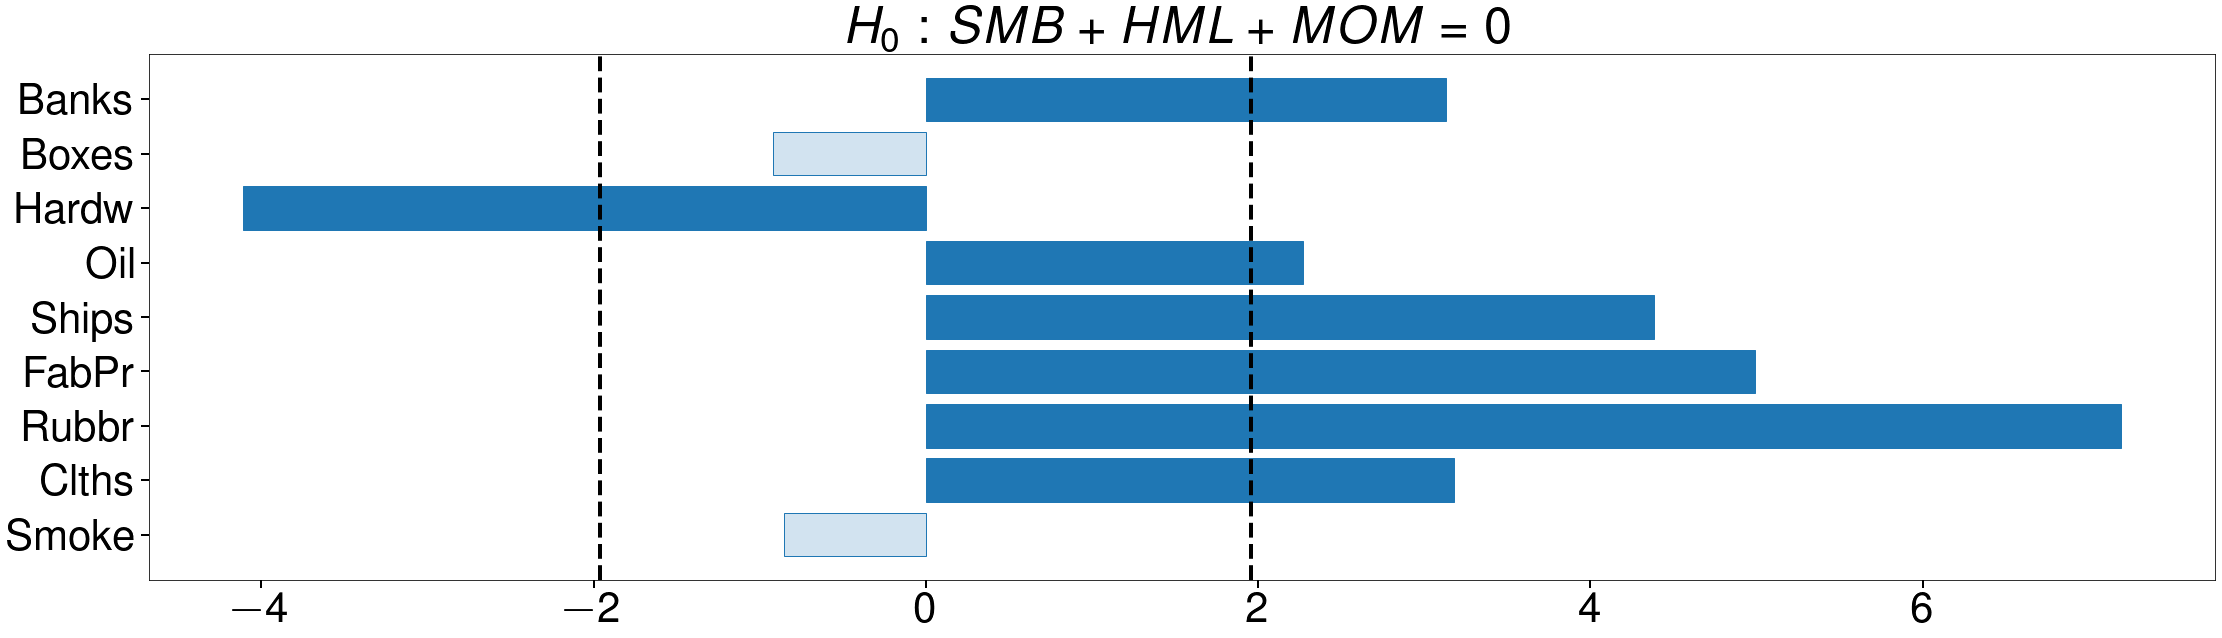

In [55]:
test_plot(t_tests, title="$H_0: SMB + HML + MOM = 0$", two_sided=True)

# Hypothesis Testing

## $t$-stats

* $t$-stat is special case for $H_0:\beta_j=0$
* Most commonly reported test statistic
* Asymptotic normal
* 5% critical values $\pm 1.96 \approx \pm 2$

In [56]:
pretty(ls.tvalues)

,
Intercept,-1.991463
VWMe,93.513503
SMB,0.109934
HML,36.380381
MOM,-2.630803


In [57]:
t_stats = {}
for col in subset:
    res = sm.OLS(subset[col], x).fit(cov_type="HC0")
    t_stats[col] = res.tvalues.iloc[1:]
t_stats = pd.DataFrame(t_stats)
t_stats = t_stats.T


def multi_test_plot(df):
    fig, ax = plt.subplots(1, df.shape[1])
    for i, col in enumerate(df):
        test_plot(df[col], ax[i], color=mfe.colors[i], title=col, two_sided=True)
    fig.tight_layout(pad=1.0)

# Hypothesis Testing

## Significance in Industry Portfolios

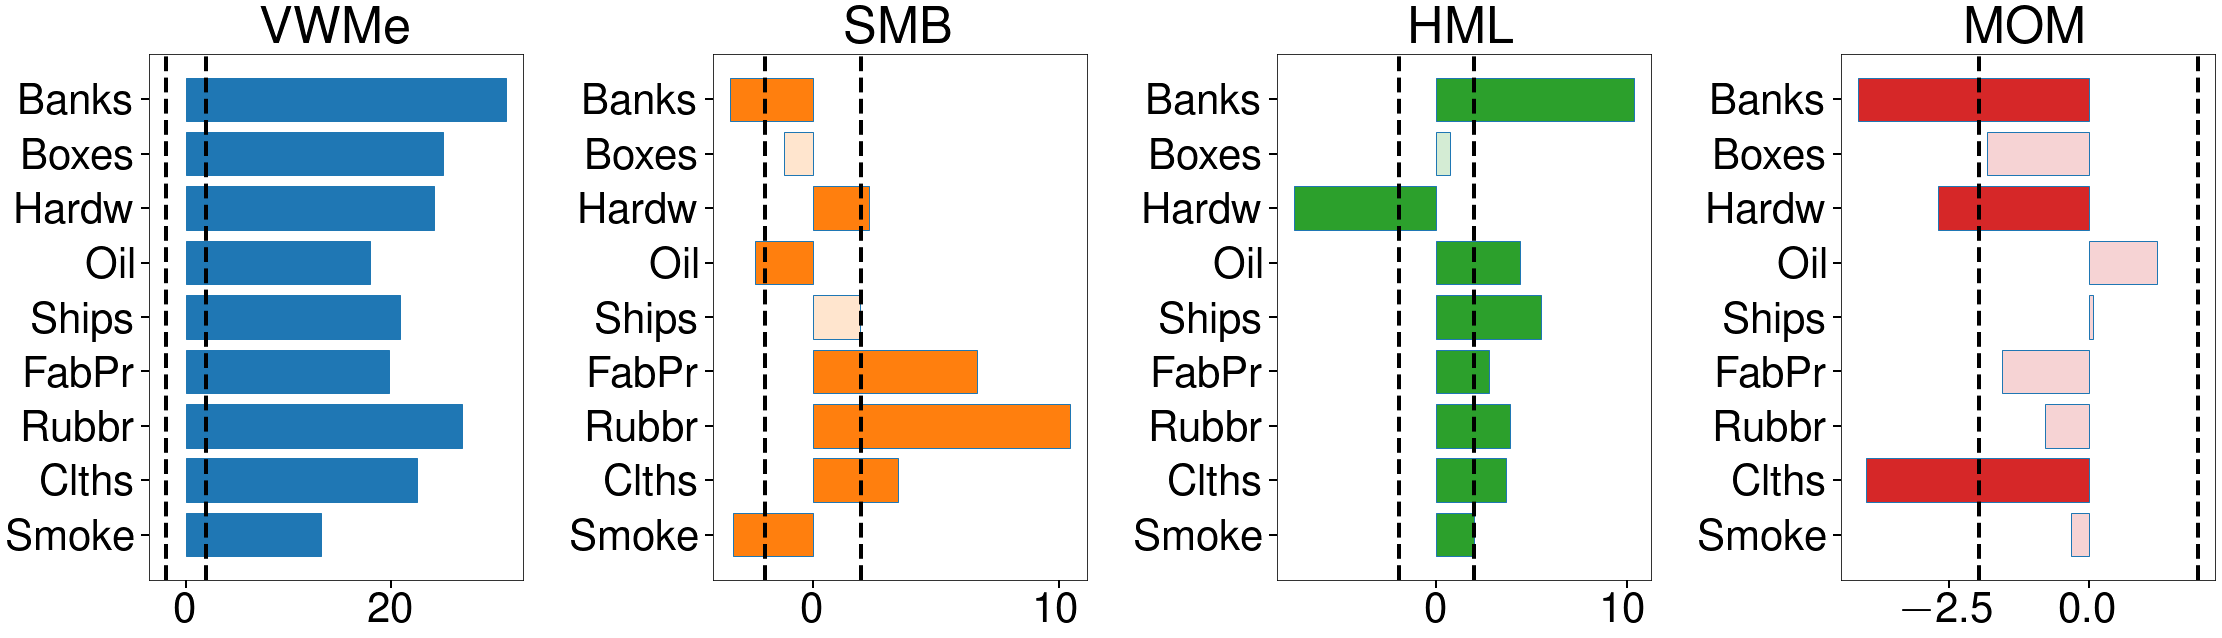

In [58]:
multi_test_plot(t_stats)

# Hypothesis Testing
## Wald Tests

* Test multiple hypothesis
* Null is

$$ H_0: \mathbf{R}\boldsymbol{\beta} = \mathbf{r} $$

* Exploit properties of multivariate normal CLT
* $\chi^2_m$ distributed in large samples
* Test statistic is 

$$ W = n\left(\mathbf{R}\hat{\boldsymbol{\beta}}-\mathbf{r}\right)^\prime
\left[\mathbf{R}\hat{\boldsymbol{\Sigma}}_{XX}^{-1}\hat{\mathbf{S}}\hat{\boldsymbol{\Sigma}}_{XX}^{-1}\mathbf{R}^\prime\right]^{-1}
\left(\mathbf{R}\hat{\boldsymbol{\beta}}-\mathbf{r}\right)$$



# Hypothesis Testing
## Wald Tests
### Testing the CAPM

* Multiple $\beta$ all zero: 

$$H_0: SMB=HML=MOM=0$$

* Restriction matrix and value

$$ R = \left[\begin{array}{ccccc} 0 & 0 & 1 & 0 & 0 \\  0 & 0 & 0 & 1 & 0 \\   0 & 0 & 0 & 0 & 1 \\ \end{array}\right], r = \left[\begin{array}{c} 0 \\ 0 \\ 0 \end{array}\right] $$


# Hypothesis Testing
## Testing the CAPM


In [59]:
R, r = np.zeros((3, 5)), np.zeros(3)
R[0, 2] = R[1, 3] = R[2, 4] = 1
h0_vcv = R @ c @ R.T
h0_vcv.columns = h0_vcv.index = [f"Restr {i}" for i in range(1, 4)]
h0_vcv

,Restr 1,Restr 2,Restr 3
Restr 1,0.000297,0.000042,0.000019
Restr 2,0.000042,0.000441,0.000122
Restr 3,0.000019,0.000122,0.000181


In [60]:
numerator = R @ ls.params - r
wald = numerator @ np.linalg.inv(h0_vcv) @ numerator.T
pretty(f"W={wald:0.1f}")

# Wald Tests
## Industry Portfolios

In [61]:
walds = {}
for col in subset:
    res = sm.OLS(subset[col], x).fit(cov_type="HC0")
    walds[col] = np.squeeze(res.wald_test(R).statistic)
walds = pd.Series(walds)
figsize(y=9)

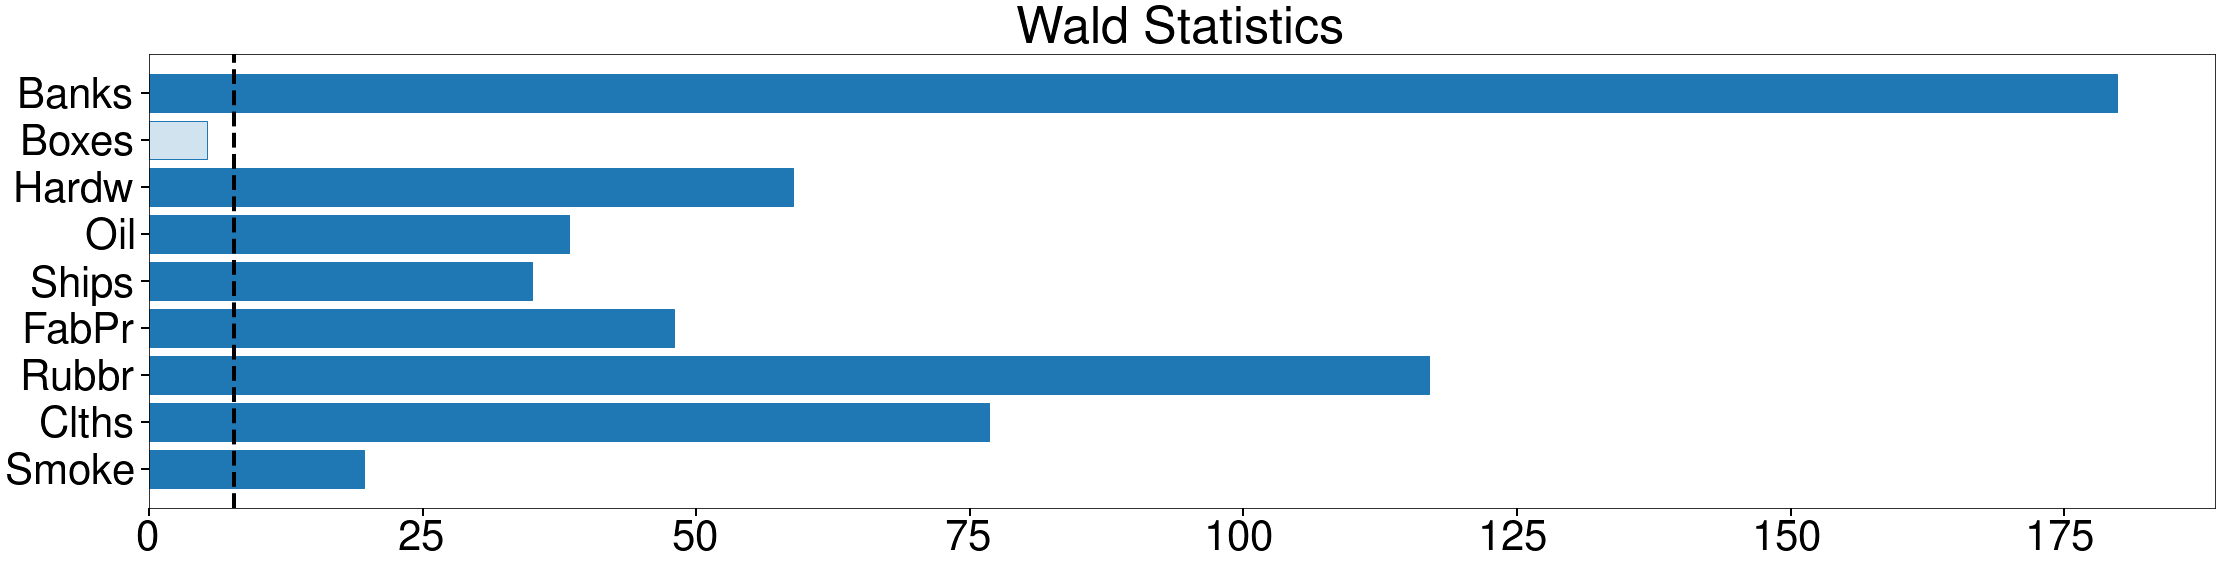

In [62]:
dof = 3
pretty(f"The crit. value is {stats.chi2(dof).ppf(0.95):0.2f} from a $\chi^2_{dof}$")
test_plot(walds, cv=stats.chi2(dof).ppf(0.95), title="Wald Statistics")

# Hypothesis Testing
## The F-stat
* Special case of Wald for
$$H_0:\beta_2=\beta_3=\ldots=\beta_k=0$$
    * _Never_ test constant

* Restrictions in 4-factor model

$$ R = \left[\begin{array}{ccccc} 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 \\  0 & 0 & 0 & 1 & 0 \\   0 & 0 & 0 & 0 & 1 \\ \end{array}\right], r = \left[\begin{array}{c} 0 \\ 0 \\ 0 \\ 0 \end{array}\right] $$

* If **no constant** then test all $\beta$
$$H_0:\beta_1=\beta_2=\ldots=\beta_k=0$$

In [63]:
f_stats = {}
R = np.c_[np.zeros((4, 1)), np.eye(4)]
for col in industries.iloc[:, 4::5]:
    res = sm.OLS(industries[col], x).fit(cov_type="HC0")
    f_stats[col] = np.squeeze(res.wald_test(R).statistic)
f_stats = pd.Series(f_stats)
f_stats
figsize(y=11)

# Industry F-statistics

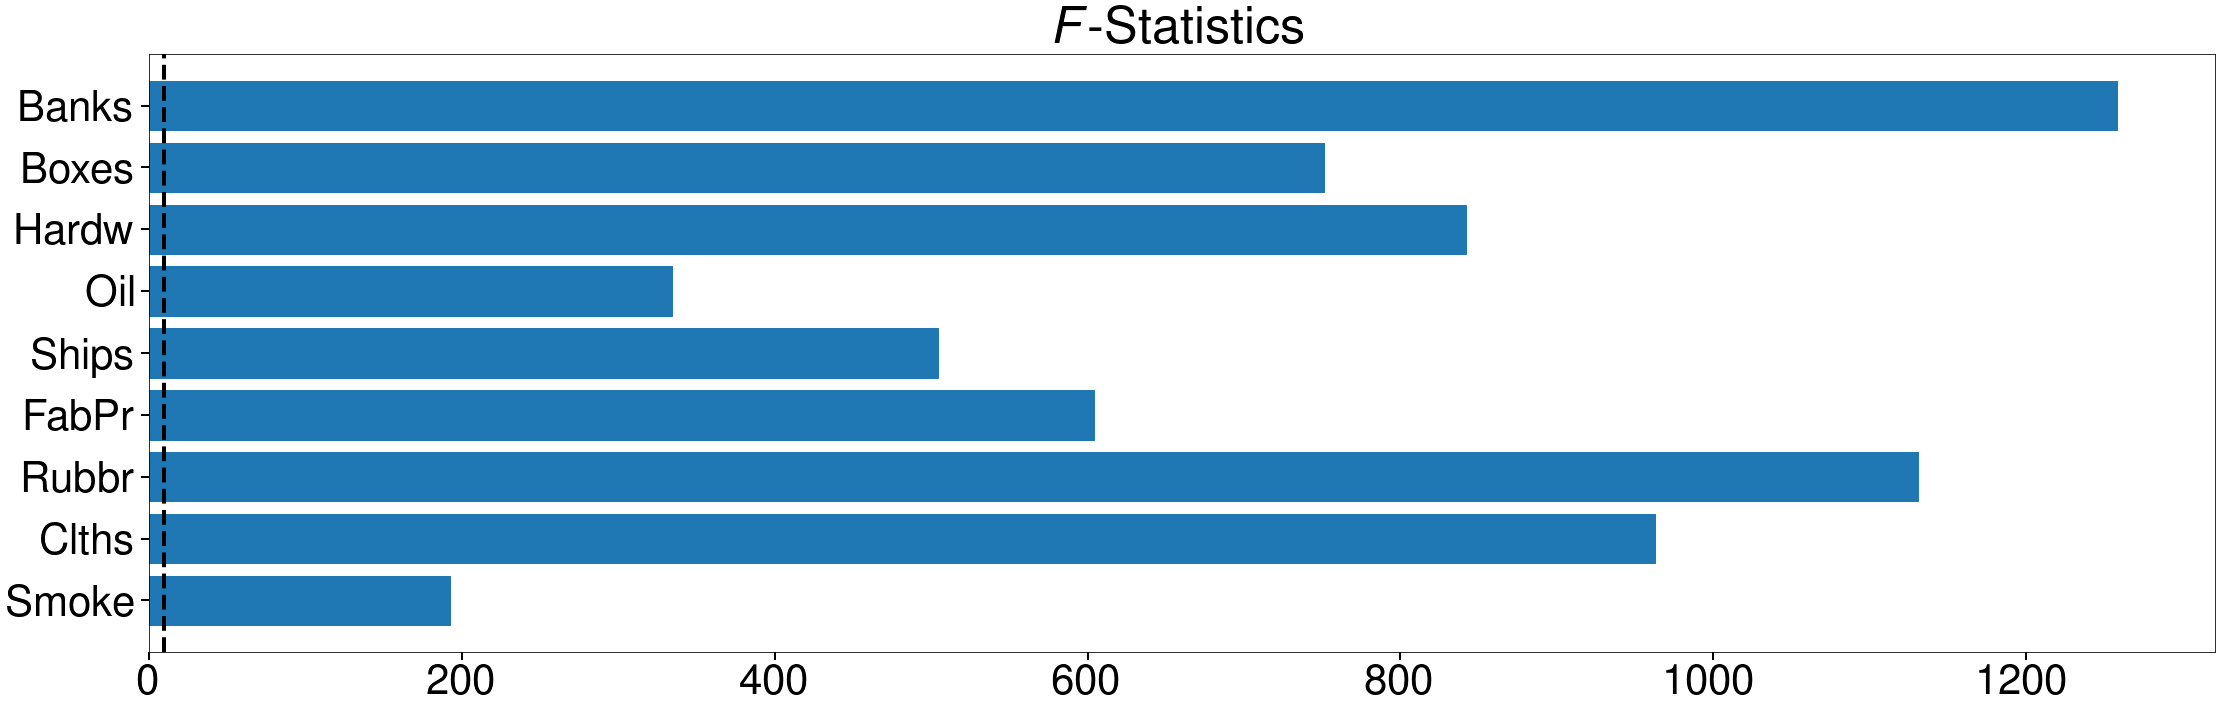

In [64]:
dof = 4
cv = stats.chi2(dof).ppf(0.95)
pretty(f"The critical value is {cv:0.2f} from a $\chi^2_{dof}$")
test_plot(f_stats, cv=cv, title="$F$-Statistics")

# Analysis of Cross-Sectional Data
##  LM and LR Tests

* Imposing a LER on a Linear Regression
* LM Tests
* LR Tests
* Comparing Wald, LM and LR tests

# Hypothesis Testing
## Imposing the null on the model

$$ H_0: \beta_{SMB} + \beta_{HML} + \beta_{MOM} = 0 \Rightarrow \beta_{SMB} = -\beta_{HML}  -\beta_{MOM} $$

Initial model

$$ Ships = \beta_1 + \beta_2 VWM^e + \beta_3 SMB + \beta_4 HML + \beta_5 MOM + \epsilon_i$$

becomes

$$ Ships = \beta_1 + \beta_2 VWM^e + (-\beta_4 -\beta_5) SMB + \beta_4 HML + \beta_5 MOM + \epsilon_i$$

and then finally 

$$ Ships = \beta_1 + \beta_2 VWM^e + \beta_4 (HML-SMB) + \beta_5 (MOM-SMB) + \epsilon_i$$

# Hypothesis Testing
## Estimating the Restricted Model

In [65]:
model = "Ships ~ 1 + VWMe + I(HML-SMB) + I(MOM-SMB)"
imposed = smf.ols(model, data).fit(cov_type="HC0")
summary(imposed)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.0676,0.202,0.335,0.738,-0.328,0.463
VWMe,1.1401,0.058,19.805,0.000,1.027,1.253
I(HML - SMB),0.1897,0.061,3.133,0.002,0.071,0.308
I(MOM - SMB),-0.1304,0.061,-2.148,0.032,-0.249,-0.011


# Hypothesis Testing
## Lagrange Multiplier (LM) tests

* Uses property that scores should be 0 when model is correct
* Define scores

$$ \tilde{s}_i = \mathbf{x}_i \tilde{\epsilon}_i $$

* Estimate score covariance using

$$ \hat{\tilde{S}} = \frac{1}{n}\sum_{i=1}^n \tilde{s}_i^\prime  \tilde{s}_i $$

* LM test statistic is defined

$$ LM = n \bar{\tilde{s}}\hat{\tilde{S}}^{-1}\bar{\tilde{s}}^\prime\stackrel{d}{\rightarrow}\chi^2_m$$

* Average score is

$$ \bar{\tilde{s}} = n^{-1}\sum_{i=1}^n \tilde{s}_i $$

# Hypothesis Testing
## The Scores Using the Restricted Residuals

In [66]:
imposed_eps = imposed.resid.to_numpy()
scores = x * imposed_eps[:, None]
mean_scores = scores.mean()
pretty(mean_scores)

,
Intercept,-1.437140e-16
VWMe,1.680030e-14
SMB,1.614948e+00
HML,1.614948e+00
MOM,1.614948e+00


In [67]:
S = scores.T @ scores / n
LM = n * mean_scores @ np.linalg.inv(S) @ mean_scores
pretty(f"The LM test statistic is {LM:0.2f}")

In [68]:
lms = {}
for col in subset:
    model = f"{col} ~ 1 + VWMe + I(HML-SMB) + I(MOM-SMB)"
    res = smf.ols(model, data).fit(cov_type="HC0")
    eps = res.resid.to_numpy()
    scores = x * eps[:, None]
    mean_scores = scores.mean()
    S = scores.T @ scores / n
    lms[col] = n * mean_scores @ np.linalg.inv(S) @ mean_scores
lms = pd.Series(lms)
figsize(y=10)

# Hypothesis Testing
## LM Tests on Industry Portfolios

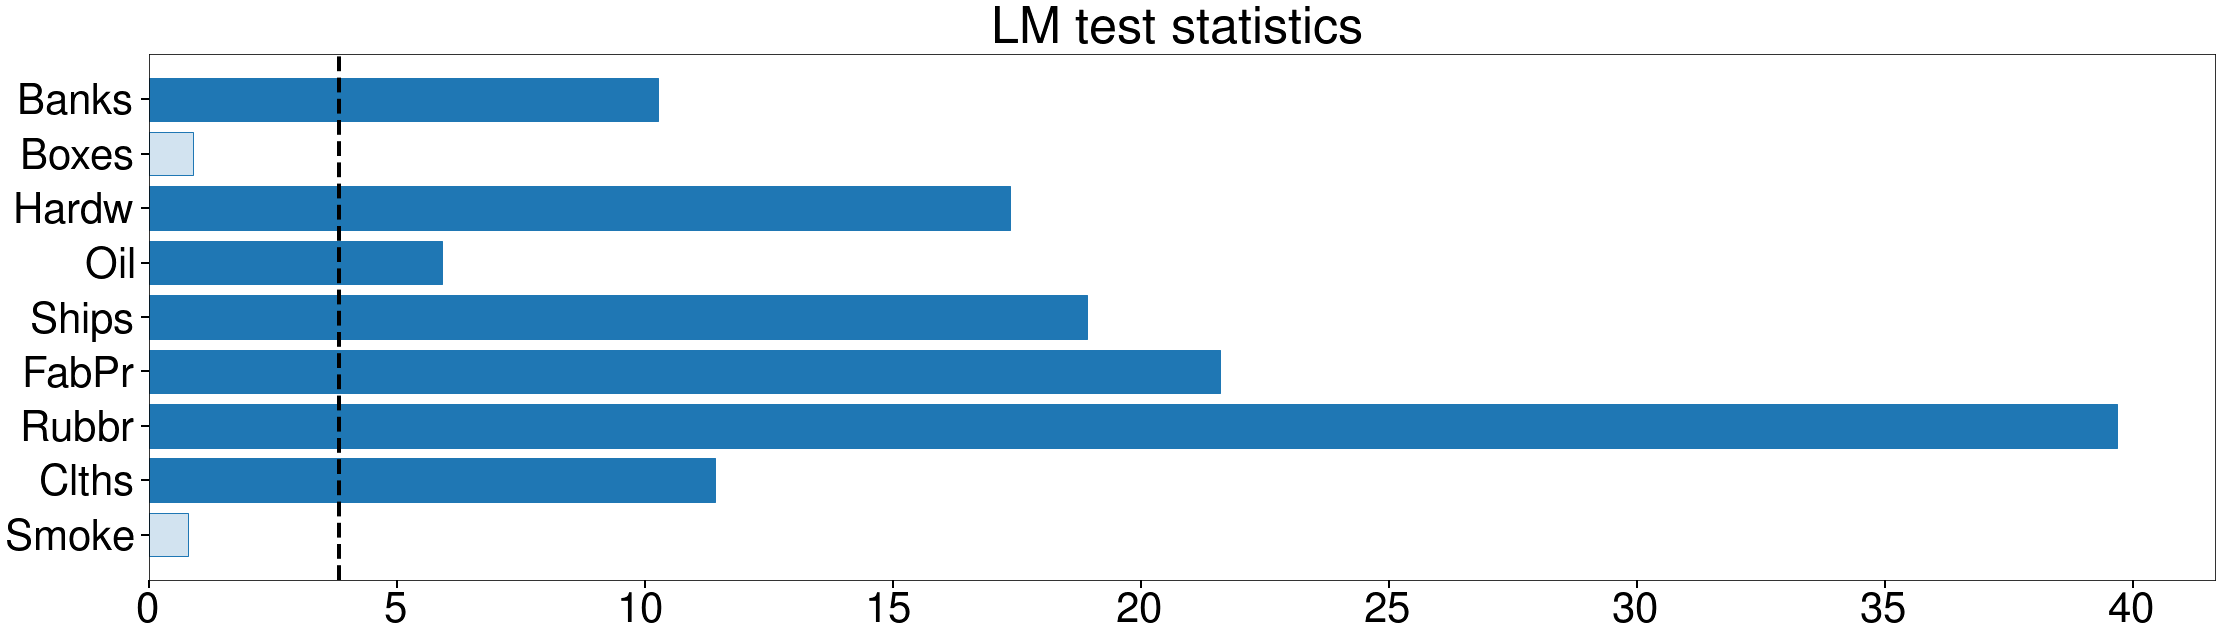

In [69]:
cv = stats.chi2(1).ppf(0.95)
pretty(f"The critical value is {cv:0.2f} from a $\chi^2_1$")
test_plot(lms, cv=cv, title="LM test statistics")

# Hypothesis Testing
## Likelihood Ratio (LR) tests


* Nearly identical to LM, only using unrestricted model to estimate score covariance
$$ \hat{s}_i = \mathbf{x}_i \hat{\epsilon}_i$$

* Covariance uses $\hat{\epsilon}_i$ instead of $\tilde{\epsilon}_i$
$$ \hat{S} = \frac{1}{n}\sum_{i=1}^n \hat{s}_i^\prime  \hat{s}_i $$

* LR test statistic is defined
$$ LR = n \bar{s}\hat{S}^{-1}\bar{s}^\prime\stackrel{d}{\rightarrow}\chi^2_m$$

# Hypothesis Testing
## Likelihood Ratio (LR) tests

In [70]:
unres = smf.ols("Ships ~ 1 + VWMe + SMB + HML + MOM", data).fit()
eps = unres.resid.to_numpy()
s_hat = x * eps[:, None]
S = s_hat.T @ s_hat / n
LR = n * mean_scores @ np.linalg.inv(S) @ mean_scores
pretty(f"The LR test statistic is {LR:0.2f}")

In [71]:
lrs = {}
for col in subset:
    res = smf.ols(f"{col} ~ 1 + VWMe + I(HML-SMB) + I(MOM-SMB)", data).fit()
    unres = smf.ols(f"{col} ~ 1 + VWMe + SMB + HML + MOM", data).fit()
    eps = res.resid.to_numpy()
    scores = x * eps[:, None]
    mean_scores = scores.mean()
    eps = unres.resid.to_numpy()
    scores = x * eps[:, None]
    S = (scores - scores.mean()).T @ scores / n
    lrs[col] = n * mean_scores @ np.linalg.inv(S) @ mean_scores
lrs = pd.Series(lrs)

# Hypothesis Testing
## LR Tests on Industry Portfolios

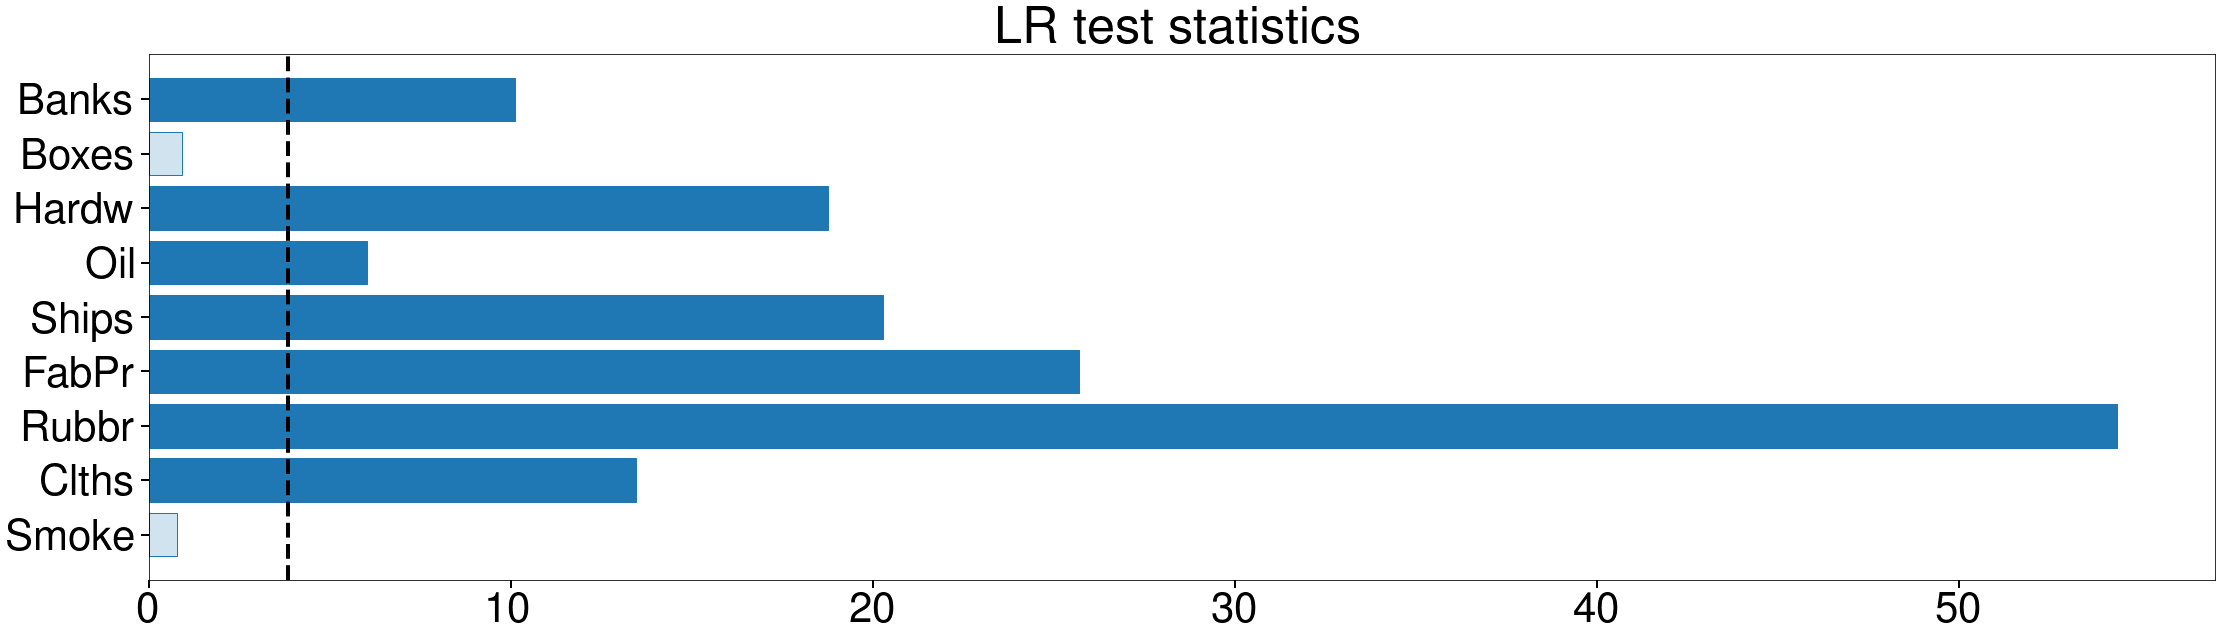

In [72]:
test_plot(lrs, cv=cv, title="LR test statistics")

In [73]:
walds = {}
for col in subset:
    res = smf.ols(f"{col} ~ 1 + VWMe + SMB + HML + MOM", data).fit(cov_type="HC0")
    R = np.array([0, 0, 1, 1, 1])
    walds[col] = float(np.squeeze(res.wald_test(R).statistic))
walds = pd.Series(walds)


def plot_three_stats():
    fig, ax = plt.subplots(1, 1)
    df = pd.DataFrame({"Wald": walds, "LM": lms, "LR": lrs})
    df.plot(ax=ax, kind="barh")
    ax.legend(frameon=False)
    return None


figsize(y=12)

# Hypothesis Testing
## Comparing the Three Classes of Test

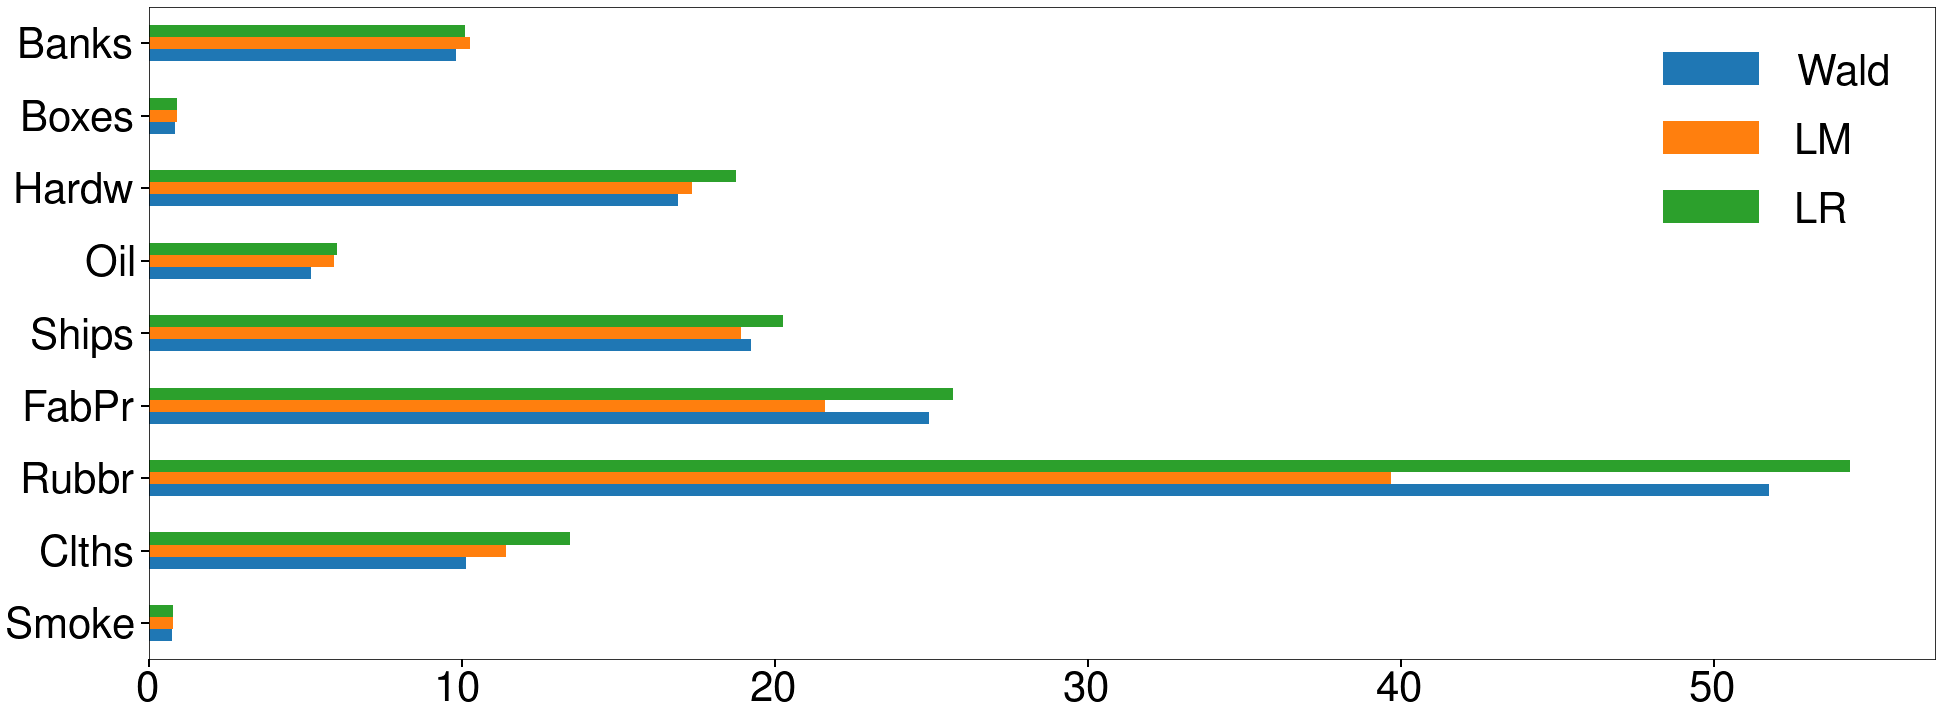

In [74]:
plot_three_stats()

# Analysis of Cross-Sectional Data
## Heteroskedasticity

* Testing for Heteroskedasticity
* Covariance Estimation for Homoskedastic Data
* Boostrap Covariance Estimation for Homoskedastic Data

# Testing for Heteroskedasticity
## White's test

* Key insight of White: Heteroskedasticity robust estimator only needed when 
$$E[\epsilon_i^2 X_{i,o} X_{i,p}] \neq \sigma^2 E[X_{i,o}X_{i,p}]$$
* Use a regression to test if covariances are all 0
$$ \hat{\epsilon}_i^2 = \mathbf{z}_i\boldsymbol{\gamma} + \eta_i $$
* $\mathbf{z}$ contains all distinct cross-products of $X$
* Test statistic is $n R^2$ from auxiliary model
* $\chi^2_{k(k+1)/2-1}$ distribution when initial model includes a constant

# Testing for Heteroskedasticity
## White's test Implementation

In [75]:
data["eps2"] = ls.resid ** 2

crosses = ""
variables = ("VWMe", "SMB", "HML", "MOM")
for i, x1 in enumerate(variables) :
    for x2 in variables[i:]:
        crosses += f"+ I({x1} * {x2})"
formula = "eps2 ~ 1 + VWMe + SMB + HML + MOM " + crosses
pretty(formula)

# Testing for Heteroskedasticity
## White's test Implementation

In [76]:
white = smf.ols(formula, data).fit()
summary(white, [0])

Dep. Variable:,eps2,R-squared:,0.109
Model:,OLS,Adj. R-squared:,0.090


In [77]:
def summary_white():
    b = white.params
    t = white.tvalues
    p = white.pvalues
    df = pd.concat([b,t,p],axis=1).T
    df.index = ["Parameter","t-test Stat.","p-value"]
    
    def stripi(v):
        if v.startswith("I("):
            v = v.strip()[2:-1]
        return v
    df.columns = [stripi(c) for c in df.columns]
    loc = np.abs(df.iloc[1]) > 1.96
    df = df.loc[:,loc]
    df = df.loc[:, [c != "Intercept" for c in df.columns]]
    display(df)
    return None

# Testing for Heteroskedasticity
## White's test Regression

* Only showing significant coefficients

In [78]:
summary_white()

,VWMe,SMB,HML * HML,HML * MOM,MOM * MOM
Parameter,-0.044663,0.063097,0.023196,0.020415,0.003795
t-test Stat.,-2.275155,2.089132,4.640325,4.133473,2.079526
p-value,0.023211,0.037072,0.000004,0.000040,0.037948


# Testing for Heteroskedasticity
## White's test statistic

In [79]:
white_stat = n * white.rsquared
pretty(f"White's stat: {white_stat:0.2f}")

In [80]:
m = 5 * (5 + 1) // 2 - 1
pretty(f"{m} restrictions. The critical value from a $\chi^2_{{{m}}}$ is {stats.chi2(m).ppf(0.95):0.1f}")

In [81]:
pvalue = 1.0 - stats.chi2(5 * (5 + 1) / 2 - 1).cdf(white_stat)
pretty(f"The p-value is {pvalue:0.3f}")

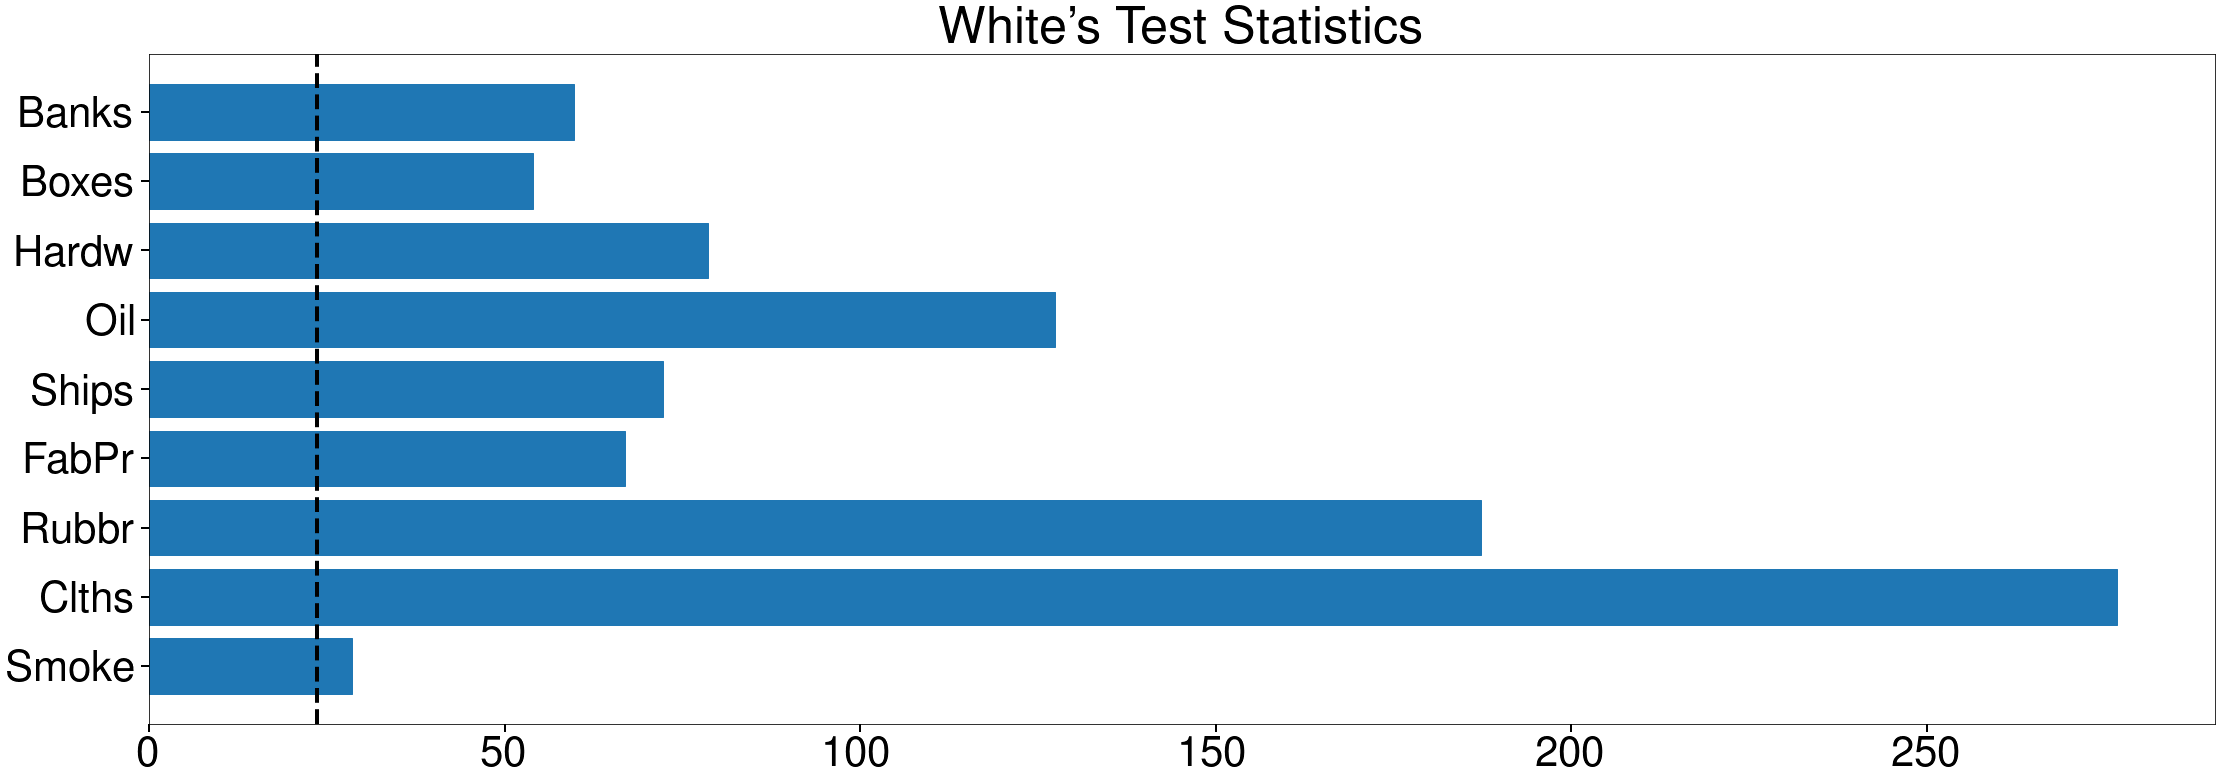

In [82]:
white_stats = {}
def white_test():
    _white_formula = "_" + formula
    for col in subset:
        res = smf.ols(f"{col} ~ 1+VWMe+SMB+HML+MOM", data).fit()
        data["_eps2"] = res.resid ** 2
        white_res = smf.ols(_white_formula, data).fit()
        white_stats[col] = white_res.rsquared * data.shape[0]
    cv = stats.chi2(white_res.params.shape[0]-1).ppf(0.95)
    fig,ax = plt.subplots(1,1)
    test_plot(pd.Series(white_stats),title="White's Test Statistics", cv=cv, ax=ax)
    ylim = ax.get_ylim()
white_test()
        

# Characterizing Parameter Estimation Error
## Homoskedastic Data

* Central Limit Theorem when residuals are homoskedastic

$$\sqrt{n}\left(\hat{\boldsymbol{\beta}}_n-\boldsymbol{\beta}\right) \stackrel{d}{\rightarrow} N\left(\mathbf{0},\sigma^2\boldsymbol{\Sigma}_{XX}^{-1}\right)$$

* Covariance components $\boldsymbol{\Sigma}_{XX} = E\left[\mathbf{x}_i^\prime\mathbf{x}_i\right]$ and $\sigma^2=E[\epsilon_i^2]$.

* In practice

$$\hat{\boldsymbol{\beta}}_n \stackrel{\approx}{\sim}N\left(\boldsymbol{\beta},\frac{\hat{\sigma}^2\hat{\boldsymbol{\Sigma}}_{XX}^{-1}}{n}\right) $$


# Characterizing Parameter Estimation Error
 
## The Homoskedastic Parameter Covariance Estimator

In [83]:
ls_homo = smf.ols("Smoke ~ 1 + VWMe + SMB + HML + MOM", data).fit()
summary(ls_homo)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5512,0.209,2.642,0.008,0.142,0.961
VWMe,0.7334,0.049,14.917,0.000,0.637,0.830
SMB,-0.2761,0.070,-3.948,0.000,-0.413,-0.139
HML,0.1671,0.075,2.243,0.025,0.021,0.313
MOM,-0.0204,0.050,-0.407,0.684,-0.119,0.078


In [84]:
def compare_tstats():
    ls = smf.ols("Smoke ~ 1 + VWMe + SMB + HML + MOM", data).fit(cov_type="HC0")
    df = pd.concat([ls_homo.params, ls_homo.bse, ls_homo.tvalues, ls.bse, ls.tvalues],1)
    mi = pd.MultiIndex.from_arrays([["","Homoskedastic","Homoskedastic","Heteroskedastic","Heteroskedastic"],["param","std err","t","std err","t"]])
    df.columns = mi
    return df

# Comparing Std Errors and $t$-stats

In [85]:
compare_tstats()

Homoskedastic            Heteroskedastic           
              param       std err          t         std err          t
Intercept  0.551242      0.208643   2.642032        0.209665   2.629153
VWMe       0.733354      0.049162  14.917088        0.055700  13.166200
SMB       -0.276084      0.069932  -3.947901        0.085450  -3.230931
HML        0.167094      0.074507   2.242654        0.084861   1.969042
MOM       -0.020364      0.049996  -0.407308        0.063151  -0.322460

# Characterizing Parameter Estimation Error
## The Homoskedastic Parameter Covariance Estimator

In [86]:
ls_homo.cov_params()

,Intercept,VWMe,SMB,HML,MOM
Intercept,0.043532,-0.001698,-0.000538,-0.002558,-0.002149
VWMe,-0.001698,0.002417,-0.000916,0.000814,0.000477
SMB,-0.000538,-0.000916,0.004890,0.000589,0.000019
HML,-0.002558,0.000814,0.000589,0.005551,0.000882
MOM,-0.002149,0.000477,0.000019,0.000882,0.002500


In [87]:
tvalues = {}
for col in subset:
    mod = smf.ols(f"{col} ~ 1 + VWMe + SMB + HML + MOM", data)
    homosk = mod.fit()
    heterosk = mod.fit(cov_type="HC0")
    tvalues[col] = pd.concat([homosk.tvalues[1:], heterosk.tvalues[1:]])
tvalues = pd.DataFrame(tvalues)
tvalues = tvalues.T


def plot_tvalues():
    fig, axes = plt.subplots(1, 4)
    for i in range(4):
        sub = tvalues.iloc[:, [i, i + 4]]
        sub.columns = ["Homosk.", "Heterosk."]
        (sub)
        sub.plot(kind="barh", ax=axes[i], legend=False)
        if i > 0:
            axes[i].set_yticklabels([])
        axes[i].set_title(factors.columns[i])
        if i == 1:
            axes[i].legend(frameon=False)

    fig.tight_layout(pad=1.0)

# Heteroskedasticity vs Homoskedasticity
## Industry Portfolios

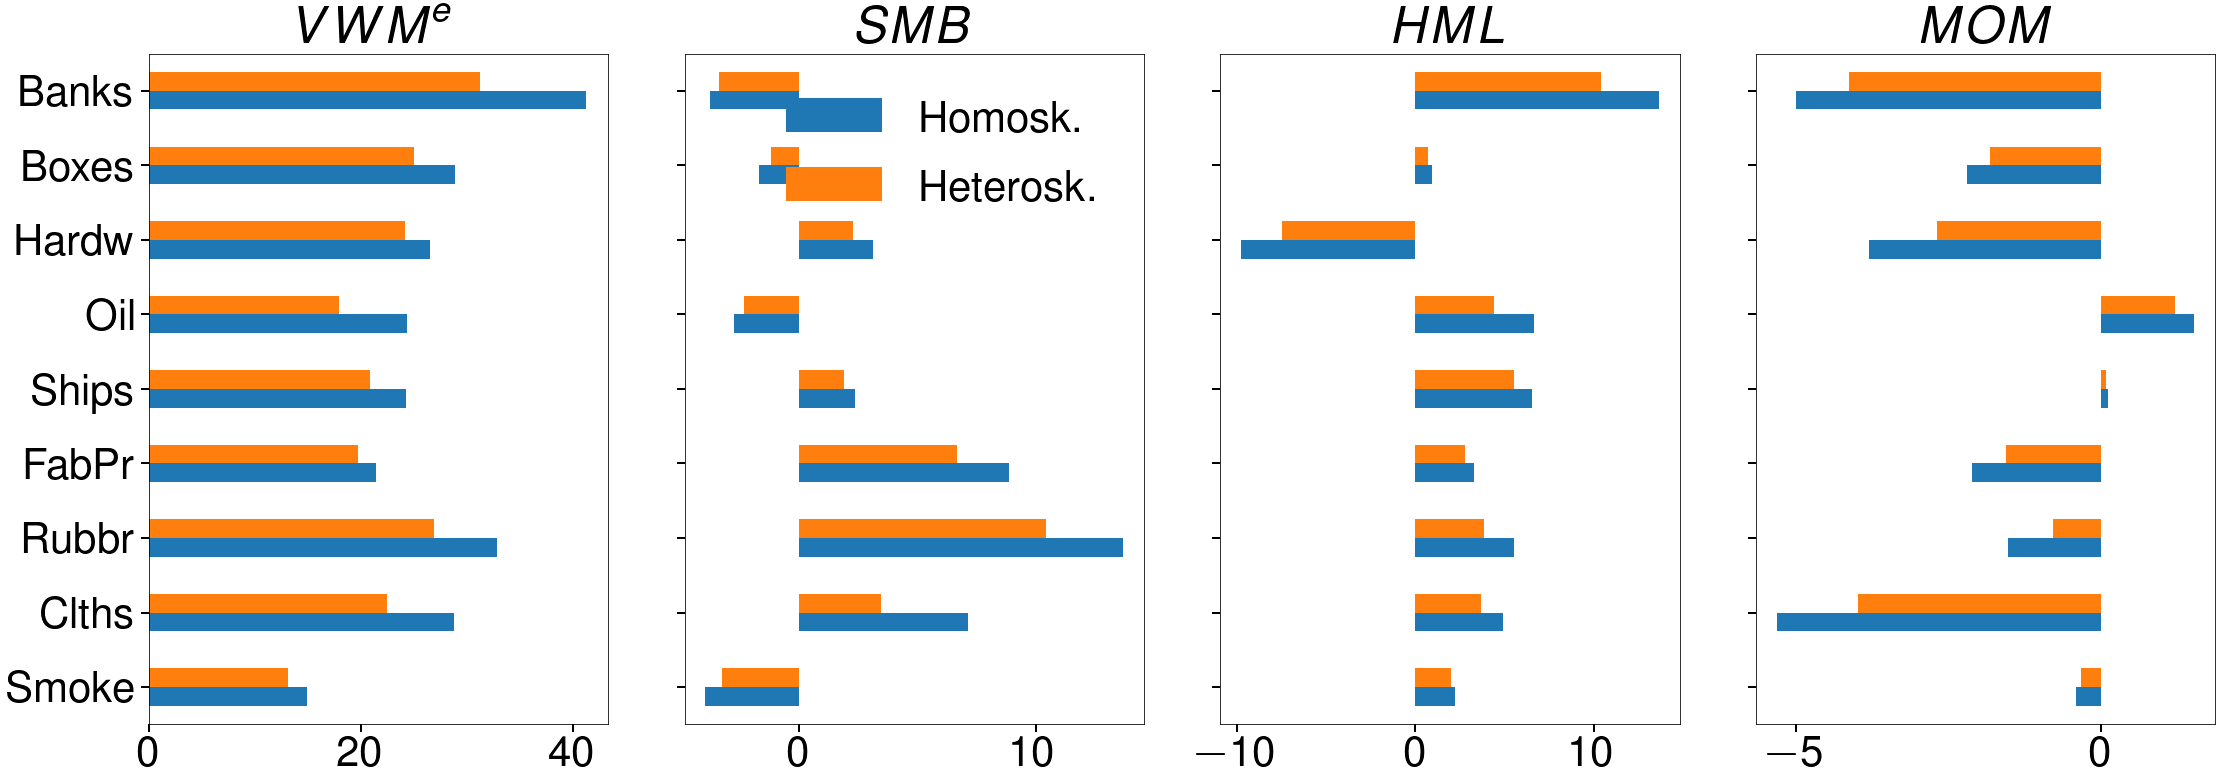

In [88]:
plot_tvalues()

# Bootstrap for Homoskedastic Data

* If data are homoskedastic can use improved bootstrap
* Independently sample $\hat{\epsilon}_i$ and $\mathbf{x}_j$ and then build simulated $\tilde{Y}_m = \mathbf{x}_j \hat{\boldsymbol{\beta}} + \hat{\epsilon}_i$ 
* Estimate model on bootstrapped data
* Repeat $b=1,2,\ldots,B$ times and compute covariance of estimated $\hat{\boldsymbol{\beta}}_b$


# Bootstrap for Homoskedastic Data


In [89]:
eps = ls.resid.to_numpy()
betas = []
g = np.random.default_rng(2020)
x = ls.model.data.orig_exog
for i in range(1000):
    x_idx = g.integers(n, size=n)
    xb = x.iloc[x_idx]
    eps_idx = g.integers(n, size=n)
    y = xb @ ls.params + eps[eps_idx]
    beta = sm.OLS(y, xb).fit().params
    betas.append(beta)
betas = np.array(betas)

betas = pd.DataFrame(betas, columns=x.columns)

# Bootstrap for Homoskedastic Data


In [90]:
betas.cov()

,Intercept,VWMe,SMB,HML,MOM
Intercept,0.001796,-0.000077,0.000007,-0.000104,-0.000095
VWMe,-0.000077,0.000098,-0.000030,0.000032,0.000013
SMB,0.000007,-0.000030,0.000198,0.000026,0.000011
HML,-0.000104,0.000032,0.000026,0.000229,0.000040
MOM,-0.000095,0.000013,0.000011,0.000040,0.000103


# Analysis of Cross-Sectional Data
## Model Selection

* General-to-Specific
* Specific-to-General
* Information Criteria
* Cross-Validation

# Model Selection
## General-to-Specific
* Start with full model
* Drop variables one-at-a-time when P-value > $\alpha$
    * Typical sizes 1% or .1%

In [91]:
res = smf.ols("Ships ~ 1 + VWMe + SMB + HML + MOM", data).fit(cov_type="HC0")
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1420,0.204,-0.697,0.486,-0.541,0.257
VWMe,1.1551,0.055,20.872,0.000,1.047,1.264
SMB,0.1604,0.084,1.898,0.058,-0.005,0.326
HML,0.4703,0.085,5.513,0.000,0.303,0.637
MOM,0.0055,0.074,0.074,0.941,-0.140,0.151


# General-to-Specific Model Selection

In [92]:
res = smf.ols("Ships ~ 1 + VWMe + SMB + HML", data).fit(cov_type="HC0")
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1372,0.197,-0.697,0.486,-0.523,0.248
VWMe,1.1541,0.056,20.716,0.000,1.045,1.263
SMB,0.1603,0.084,1.900,0.057,-0.005,0.326
HML,0.4683,0.086,5.474,0.000,0.301,0.636


# General-to-Specific Model Selection

In [93]:
res = smf.ols("Ships ~ 1 + VWMe + HML", data).fit(cov_type="HC0")
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1201,0.197,-0.610,0.542,-0.506,0.266
VWMe,1.1842,0.054,21.870,0.000,1.078,1.290
HML,0.4492,0.084,5.371,0.000,0.285,0.613


In [94]:
res = smf.ols("Ships ~ VWMe + HML - 1", data).fit(cov_type="HC0")
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
VWMe,1.1802,0.054,22.045,0.000,1.075,1.285
HML,0.4442,0.083,5.332,0.000,0.281,0.608


# Model Selection
## Specific-to-General
* Start with only a constant
* Add variables one-at-a-time and keep smallest P-value if > $\alpha$

In [95]:
excl = ["VWMe", "SMB", "HML", "MOM"]
for reg in excl:
    res = smf.ols(f"Ships ~ 1 + {reg}", data).fit(cov_type="HC0")
    print(f"{reg}: {res.pvalues[reg]:0.3f}")

VWMe: 0.000
SMB: 0.000
HML: 0.793
MOM: 0.014


# Specific-to-General
## Removing insignficant variables

In [96]:
excl.remove("VWMe")
for reg in excl:
    res = smf.ols(f"Ships ~ 1 + VWMe + {reg}", data).fit(cov_type="HC0")
    print(f"{reg}: {res.pvalues[reg]:0.3f}")

SMB: 0.263
HML: 0.000
MOM: 0.386


In [97]:
excl.remove("HML")
for reg in excl:
    res = smf.ols(f"Ships ~ 1 + VWMe + HML + {reg}", data).fit(cov_type="HC0")
    print(f"{reg}: {res.pvalues[reg]:0.3f}")

SMB: 0.057
MOM: 0.947


# Model Selection

## Information Criteria

* Information criteria trade-off fit and cost for additional penalties
* Two most common: AIC and BIC
* Select model that produces the smallest IC from candidate models

In [98]:
capm = smf.ols("Ships ~ 1 + VWMe", data).fit()
factor2 = smf.ols("Ships ~ 1 + VWMe + SMB", data).fit()
pretty(f"CAPM AIC: {capm.aic:0.1f}, BIC: {capm.bic:0.1f}")
pretty(f"2 Factor AIC: {factor2.aic:0.1f}, BIC: {factor2.bic:0.1f}")

In [99]:
from itertools import combinations

x = []
excl = ["SMB", "HML", "MOM"]

for v in (list(combinations(excl, i)) for i in range(1, 4)):
    x += v
base = "Ships ~ 1 + VWMe + "
mods = [base + " + ".join(incl) for incl in x]
ic = {}


def clean_key(k):
    key = k.split("~")[-1].strip().replace("1 +", "").strip()
    return ",".join([v.strip() for v in key.split("+")])


for mod in mods:
    res = smf.ols(mod, data).fit()
    key = clean_key(mod)
    ic[key] = [res.aic, res.bic]
ics = pd.DataFrame(ic, index=["AIC", "BIC"]).T


def plot_ics():
    ics.index = ["\n".join(idx.split(",")) for idx in ics.index]
    ax = ics.plot(rot=0)
    ax.set_xticks(np.arange(len(ics)))
    ax.set_xticklabels(list(ics.index))
    iloc = np.argmin(ics.AIC)
    ax.plot(
        [iloc], [ics.AIC.iloc[iloc]], color=mfe.colors[0], marker="o", markersize=48
    )
    iloc = np.argmin(ics.BIC)
    ax.plot(
        [iloc], [ics.BIC.iloc[iloc]], color=mfe.colors[1], marker="o", markersize=48
    )
    ax.set_xlim(-0.1, ics.shape[0] - 1 + 0.1)
    fig = ax.get_figure()
    fig.tight_layout(pad=1.0)
figsize(y=8)    

# Model Selection
## Global IC Search

In [100]:
pretty(ics.idxmin())

,
AIC,"VWMe,SMB,HML"
BIC,"VWMe,HML"


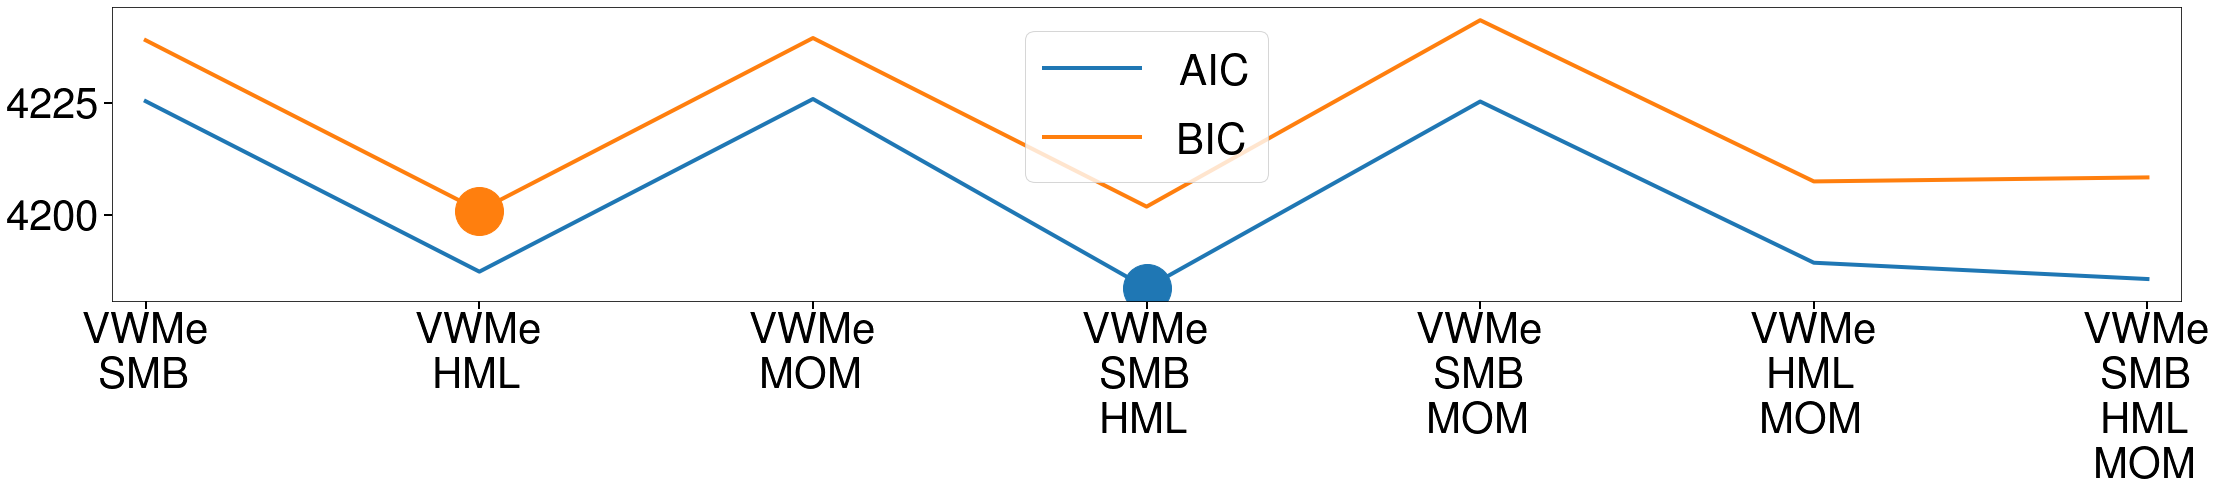

In [101]:
plot_ics()

# Model Selection

## $k$-fold Cross-validation

* Focus on pseudo-out-of-sample prediction
* Split data into $k$ equally sized  random blocks
* Estimate parameters using $k-1$ blocks
* Evaluate $SSE$ using block not used in estimation
* Repeat $k$ times in total computing the $SSE$ once in each block
* Sum $k$ $SSE$ values into $SSE_{xv}$
* Choose model with the lowest out-of-sample $SSE_{xv}$

# Model Selection

## $k$-fold Cross-validation in Practice

In [102]:
mod = "Ships ~ 1 + VWMe + SMB + HML + MOM"
rg = np.random.default_rng(132217111120)
idx = rg.permutation(n)
fifth = n / 5
xv_errors = data.Ships.copy()
for i in range(5):
    reserve = idx[int(i * fifth) : int((i + 1) * fifth)]
    use = np.setdiff1d(idx, reserve)
    beta = smf.ols(mod, data.iloc[use]).fit().params
    xv_predictions = smf.ols(mod, data.iloc[reserve]).predict(beta)
    xv_errors.iloc[reserve] = data.Ships.iloc[reserve] - xv_predictions
sse_xv = (xv_errors ** 2).sum()
full_res = smf.ols(mod, data).fit()
pretty(f"XV SSE: {sse_xv:0.1f}, In-sample SSE: {n*full_res.mse_resid:0.1f}")

In [103]:
def xv_mod(mod, data, k):
    assert k > 0
    assert isinstance(k, int)
    assert isinstance(mod, str)
    rg = np.random.default_rng(132217111120)
    idx = rg.permutation(n)
    fold = n / k
    y = data.Ships.copy()
    xv_errors = y.copy()

    for i in range(5):
        reserve = idx[int(i * fifth) : int((i + 1) * fifth)]
        use = np.setdiff1d(idx, reserve)
        beta = smf.ols(mod, data.iloc[use]).fit().params
        xv_predictions = smf.ols(mod, data.iloc[reserve]).predict(beta)
        xv_errors.iloc[reserve] = y.iloc[reserve] - xv_predictions
    return (xv_errors ** 2).sum()


xv_sses = {clean_key(mod): xv_mod(mod, data, 5) for mod in mods}
xv_sses = pd.Series(xv_sses)


def xv_plot():
    fig, ax = plt.subplots(1, 1)
    xv_sses.index = ["\n".join(idx.split(",")) for idx in xv_sses.index]
    ax = xv_sses.plot(ax=ax, rot=0, color=mfe.colors[4])
    ax.set_xticks(np.arange(len(xv_sses)))
    ax.set_xticklabels(list(xv_sses.index))
    iloc = np.argmin(xv_sses)
    ax.plot(
        [iloc], [xv_sses.iloc[iloc]], color=mfe.colors[4], marker="o", markersize=48
    )
    ax.set_xlim(-0.1, xv_sses.shape[0] - 1 + 0.1)
    ax.set_ylabel("$SSE_{xv}$")
    fig = ax.get_figure()
    fig.tight_layout(pad=1.0)
figsize(y=12)    

# Model Selection
## Cross-validation

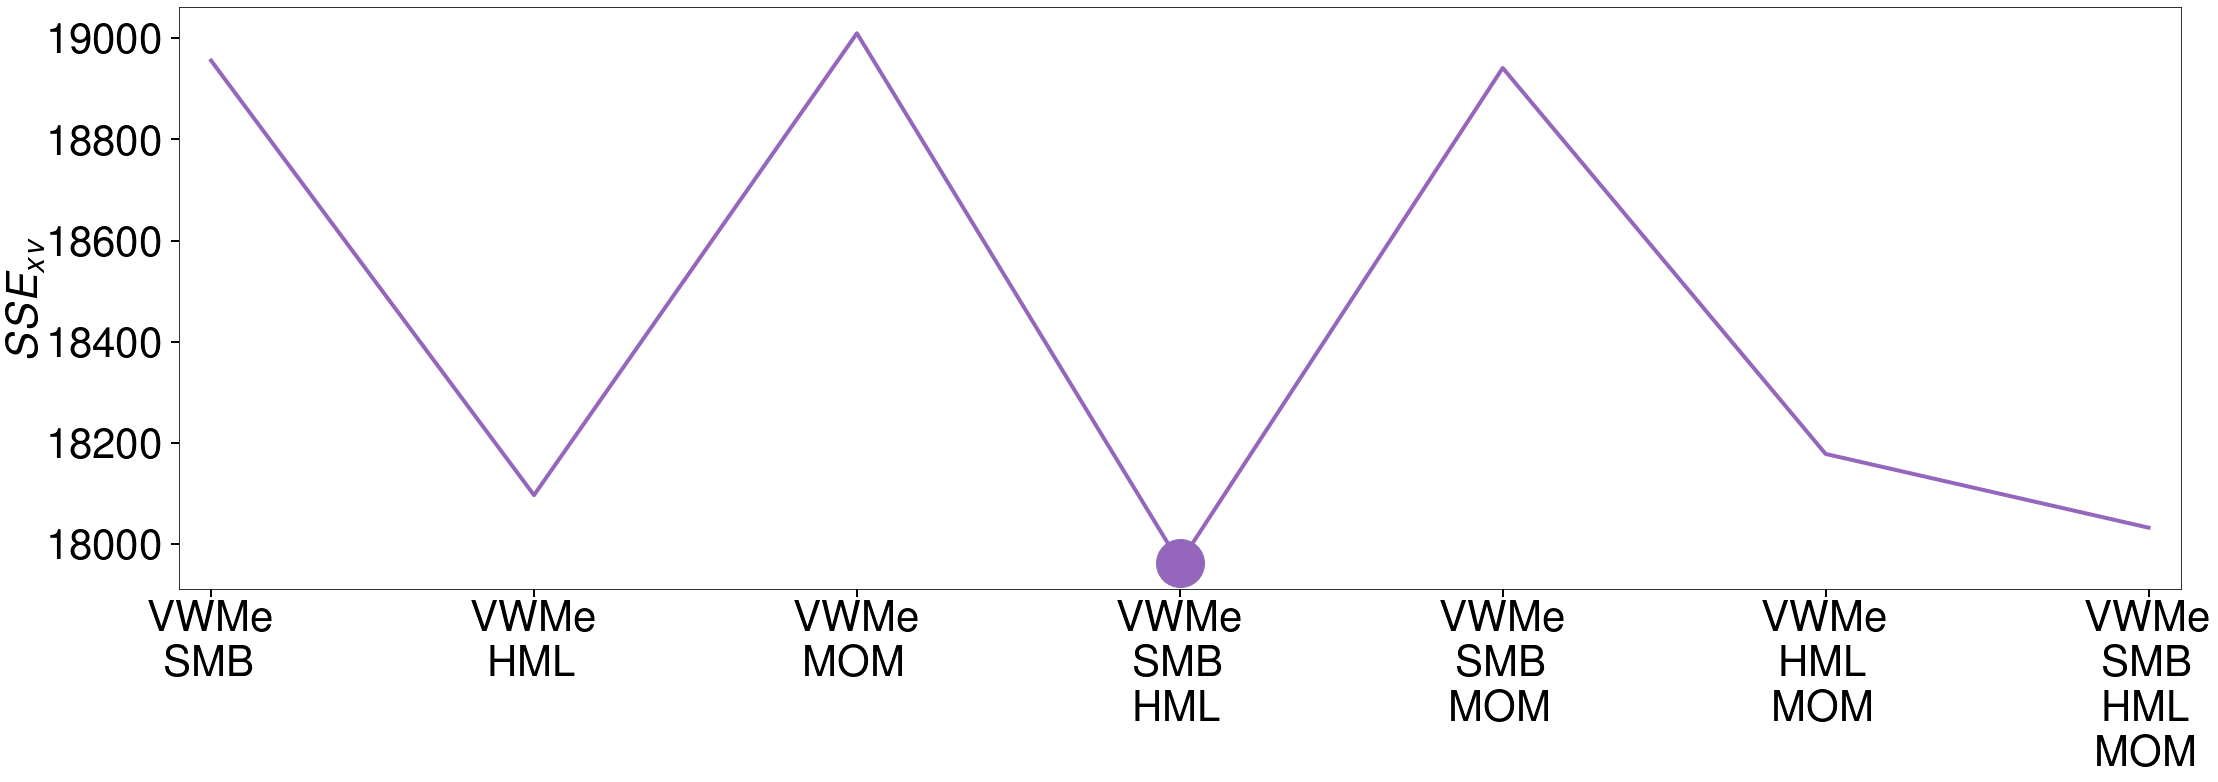

In [104]:
xv_plot()

# Analysis of Cross-Sectional Data
## Checking for Specification Errors
* Testing Structural Stability
* Testing for Neglected Nonlinearities
* Visual Diagnostics
<!-- * Trimming and Windsorization -->


# Specification Testing

## The Chow Test

* Chow test is a stability test
* Implemented using dummy interaction variables 
$$ I_{[t > \tau]} $$
* Extend model with copy of variables interacted
$$ Y_t = \mathbf{x}_t\boldsymbol{\beta} + I_{[t > \tau]} \mathbf{x}_t\boldsymbol{\gamma} + \epsilon_t$$
* Test using a Wald test (or LM or LR) with a $\chi^2_k$ distribution

# The Chow Test

In [105]:
chow_mod = "Banks ~ 1 + VWMe + SMB + HML + MOM + IxVWMe + IxSMB + IxHML + IxMOM"
ind = data.index > pd.to_datetime("1987-10-1")
interact = data[["VWMe", "SMB", "HML", "MOM"]] * ind[:, None]
interact.columns = [f"Ix{col}" for col in interact]
both = pd.concat([data, interact], 1)
chow = smf.ols(chow_mod, both).fit(cov_type="HC0")
summary(chow, [1])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.0588,0.126,-0.465,0.642,-0.307,0.189
VWMe,1.1137,0.057,19.469,0.000,1.002,1.226
SMB,-0.0774,0.072,-1.081,0.280,-0.218,0.063
HML,0.2557,0.086,2.990,0.003,0.088,0.423
MOM,-0.2023,0.059,-3.428,0.001,-0.318,-0.087
IxVWMe,0.0683,0.073,0.942,0.346,-0.074,0.211
IxSMB,-0.0842,0.089,-0.942,0.346,-0.259,0.091
IxHML,0.5119,0.103,4.947,0.000,0.309,0.715
IxMOM,0.0977,0.069,1.422,0.155,-0.037,0.232


# The Chow Test

* Restrict the interaction terms to be 0

In [106]:
R = np.c_[np.zeros((4, 5)), np.eye(4)]
R

array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [107]:
chow_test = chow.wald_test(R)
chow_stat = float(chow_test.statistic)
chow_pvalue = chow_test.pvalue
pretty(f"The Chow statistic is {chow_stat:0.1f} and its p-value is {chow_pvalue:0.3f}")

In [108]:
chows = {}
for col in subset:
    mod = chow_mod.replace("Banks ~",f"{col} ~")
    chow = smf.ols(mod, both).fit(cov_type="HC0")
    chow_test = chow.wald_test(R)
    chows[col] = float(chow_test.statistic)
chows = pd.Series(chows)
figsize(y=10)

# Chow Test
## Industry Portfolios

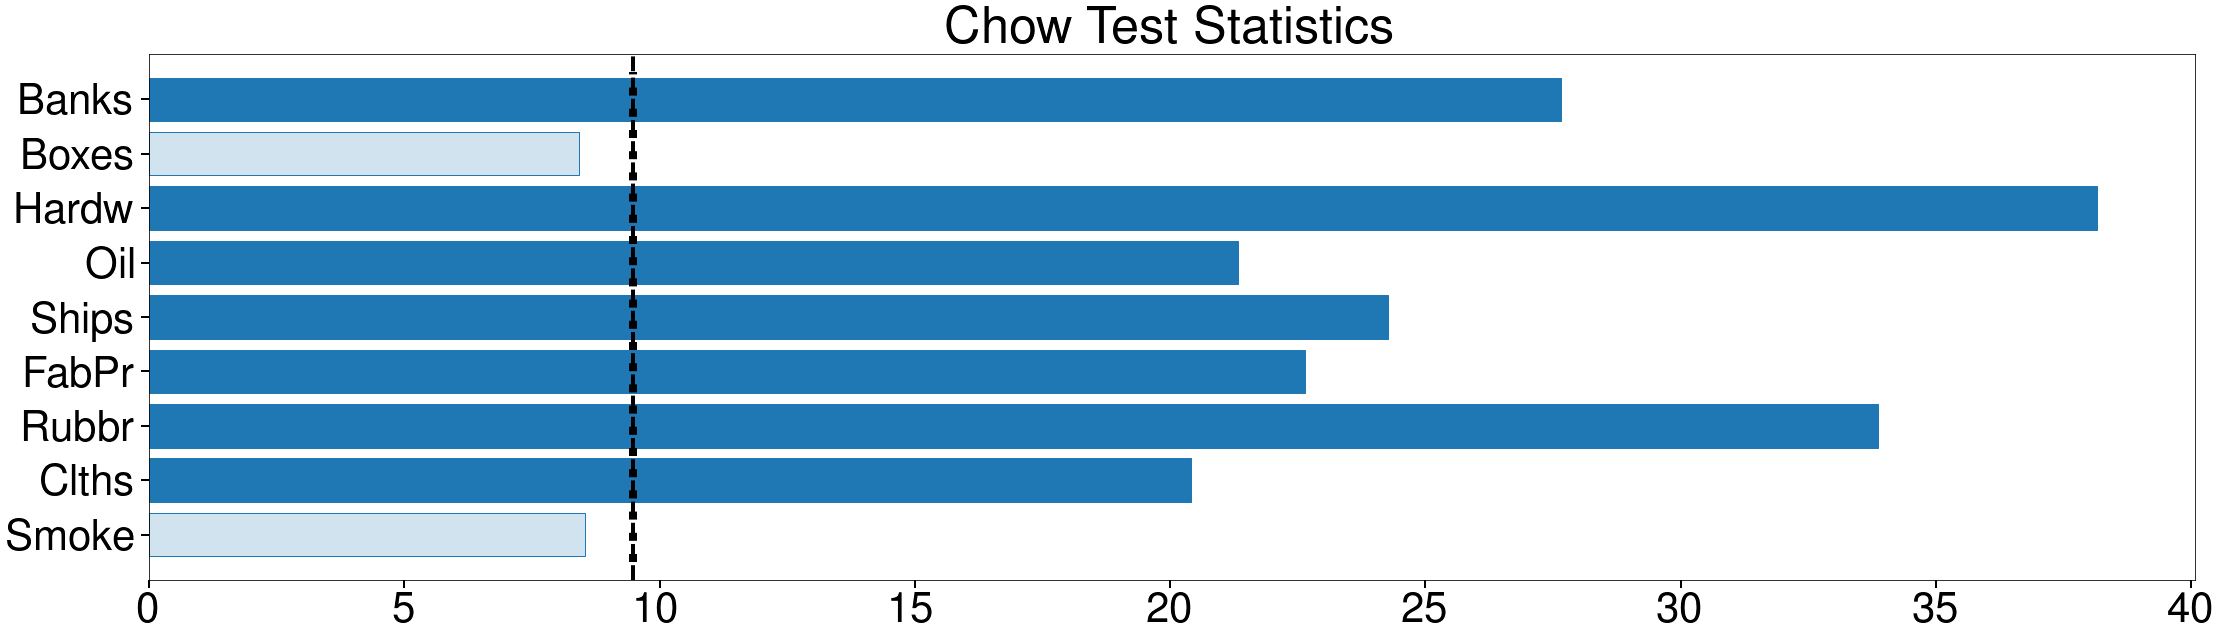

In [109]:
cv = stats.chi2(4).ppf(0.95)
test_plot(chows, title="Chow Test Statistics", cv=cv)
_ = plt.plot([cv, cv], [-0.5, 8.5], "k:", linewidth=8)

# Specification Testing
## The RESET Test

* Test for general neglected nonlinearity
* Include powers of fitted value $\hat{Y}_i^p$ in the model 
* Requires initial regression to generate fitted value $ Y_i = \mathbf{x}_i\boldsymbol{\beta} + \gamma_2 \hat{Y}_i^2 \left[ + \gamma_3 \hat{Y}_i^3 \right] + \epsilon_i $

In [110]:
first_stage = smf.ols("FabPr ~ 1 + VWMe + SMB + HML + MOM", data).fit()
data["FabPrHat"] = first_stage.predict()
reset_res = smf.ols("FabPr ~ 1 + VWMe + SMB + HML + MOM + I(FabPrHat**2)", data).fit()
test_and_pval = pd.concat([reset_res.tvalues, reset_res.pvalues], 1)
test_and_pval.columns = ["t-stat", "p-value"]

# The RESET Test Regression Results

In [111]:
test_and_pval

,t-stat,p-value
Intercept,-0.406132,6.847736e-01
VWMe,20.341804,3.244811e-72
SMB,8.877870,6.004409e-18
HML,3.095003,2.048885e-03
MOM,-2.513712,1.217672e-02
I(FabPrHat ** 2),-1.953090,5.121869e-02


In [112]:
import warnings
from statsmodels.stats.diagnostic import linear_reset

reset_stats = {}
x = ls.model.data.orig_exog
for col in subset:
    res = sm.OLS(data[col], x).fit()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        reset = linear_reset(res, power=2, cov_type="HC0")
        reset_stats[col] = float(reset.statistic)
reset_stats = pd.Series(reset_stats)

## The RESET Test
## Industry Portfolios

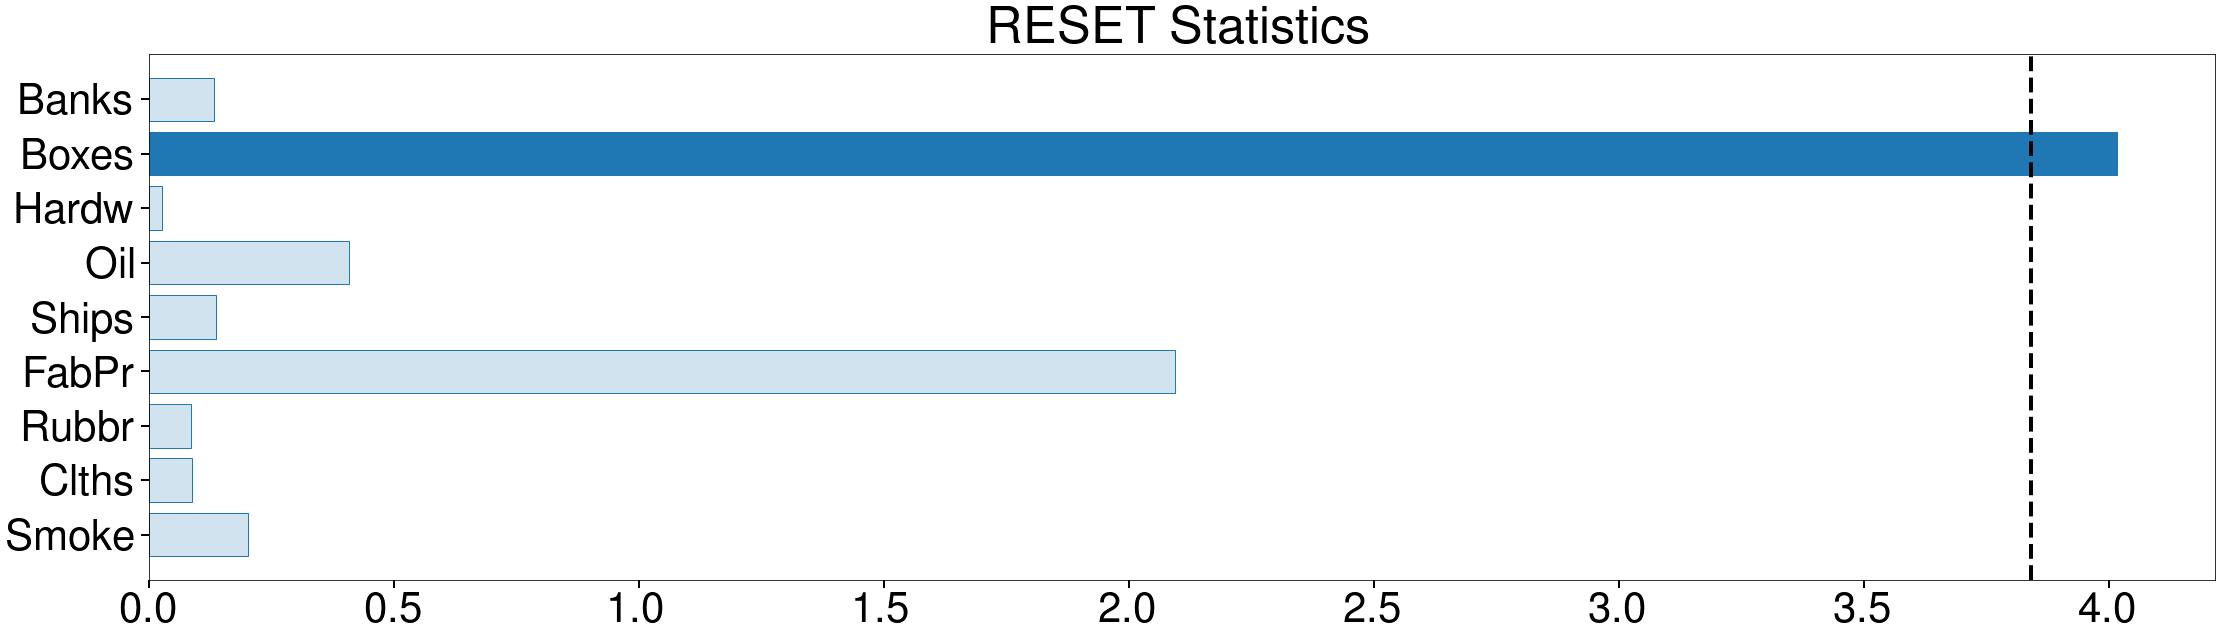

In [113]:
cv = stats.chi2(1).ppf(0.95)
test_plot(reset_stats, title="RESET Statistics", cv=cv)

# Specification Testing
## Rolling Regression Plots

* Estimate many regressions using a fixed window length
* Visual diagnostics for parameter stability
* Confidence intervals are approximate

In [114]:
figsize()
from statsmodels.regression.rolling import RollingOLS

def rolling_plot():
    mod = "Banks ~ 1 + VWMe + SMB + HML + MOM"
    rolling_res = RollingOLS.from_formula(mod, data, window=60).fit(cov_type="HC0")
    fig = rolling_res.plot_recursive_coefficient(["VWMe", "HML", "MOM"])

# Rolling Regression Plots

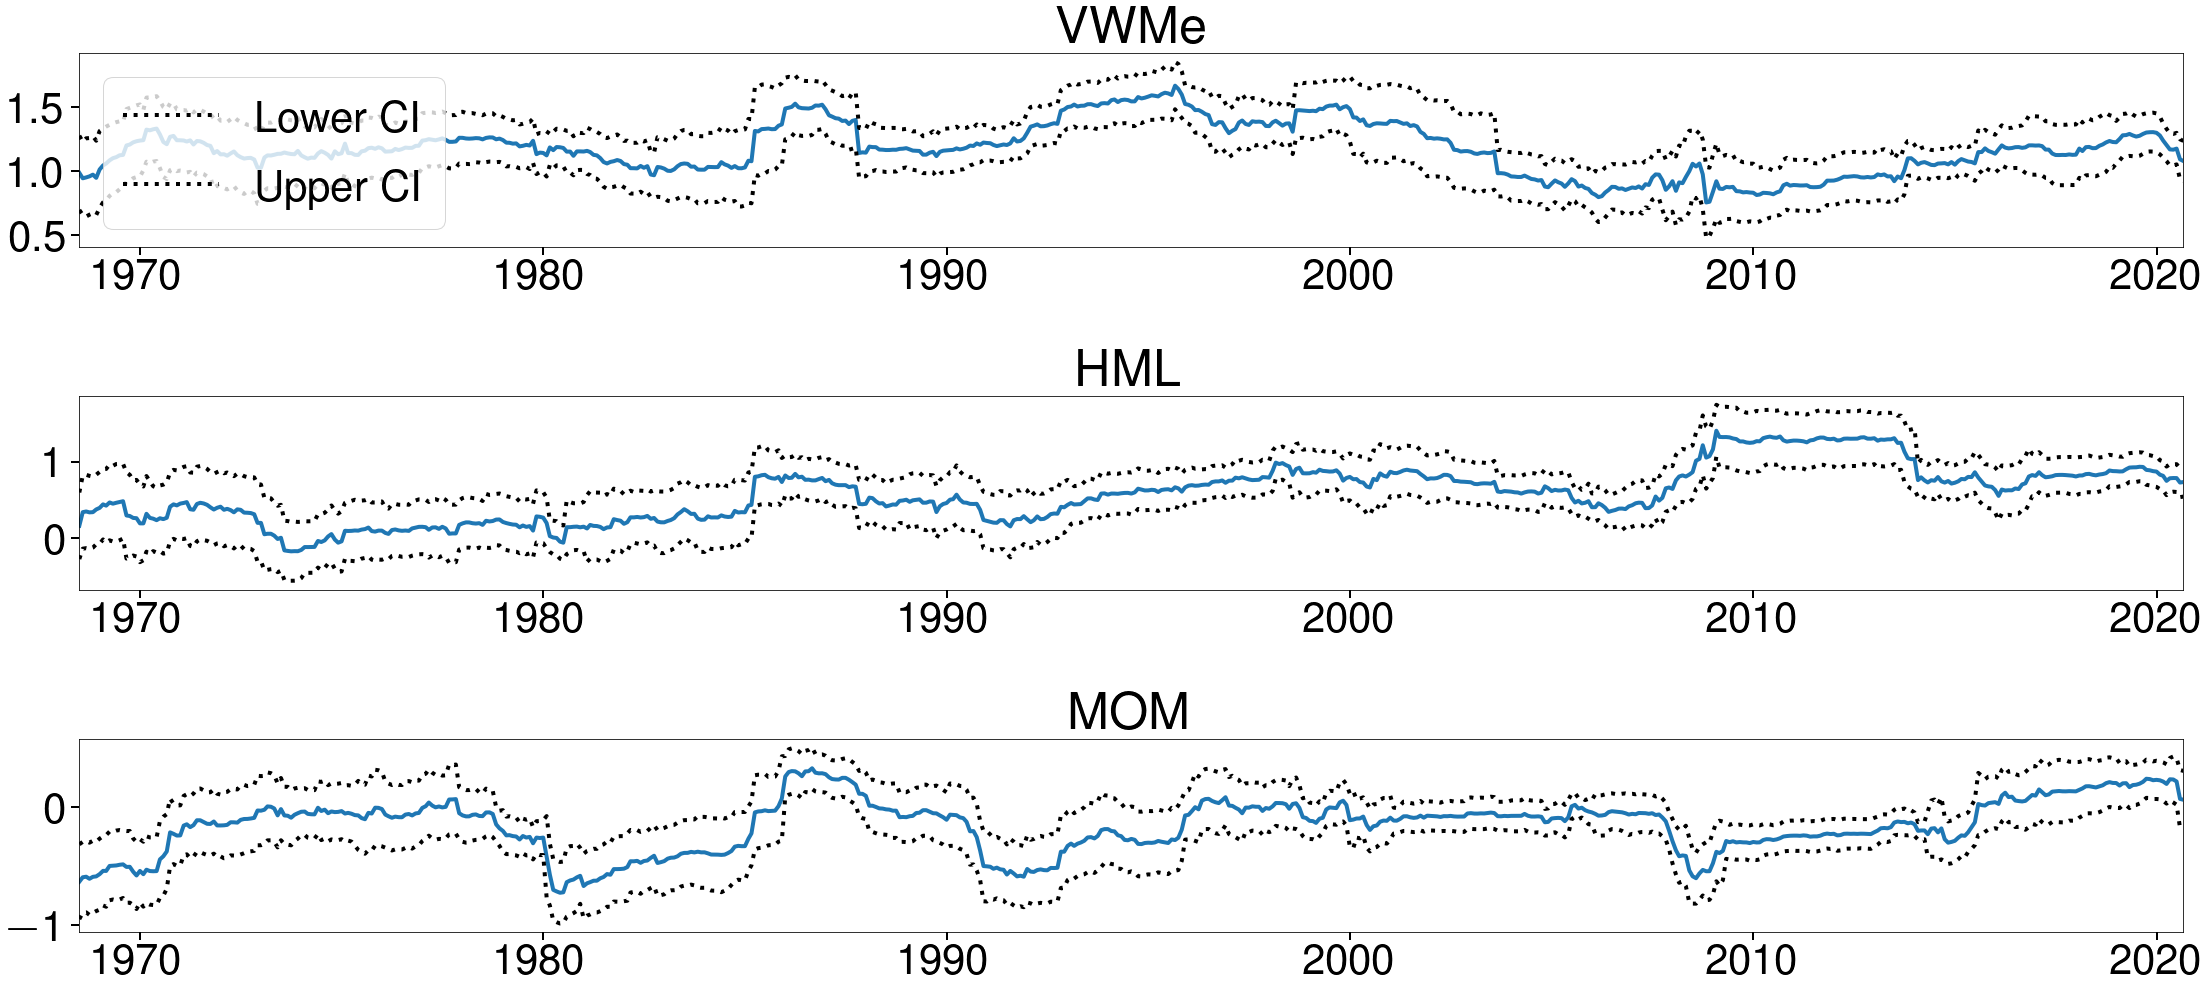

In [115]:
rolling_plot()

# Specification Testing
## Recursive Regression Plots


* Estimate many regressions using an expanding sample
* Visual diagnostics for parameter stability
* Confidence intervals are standard


In [116]:
import warnings

rec_res = sm.RecursiveLS(data.Banks, sm.add_constant(data[["VWMe","SMB","HML","MOM"]])).fit()

def recursive_plot():
    fig = plt.figure()
    rec_res.plot_recursive_coefficient(
        ["VWMe", "HML", "MOM"], legend_loc="upper right", fig=fig
    )
    axes = fig.get_axes()
    for i, ax in enumerate(axes):
        xl = np.array(ax.get_xlim()) + np.array([1000, -1000])
        ax.set_xlim(xl)
        ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)
    return None


figsize()

# Recursive Regression Plots

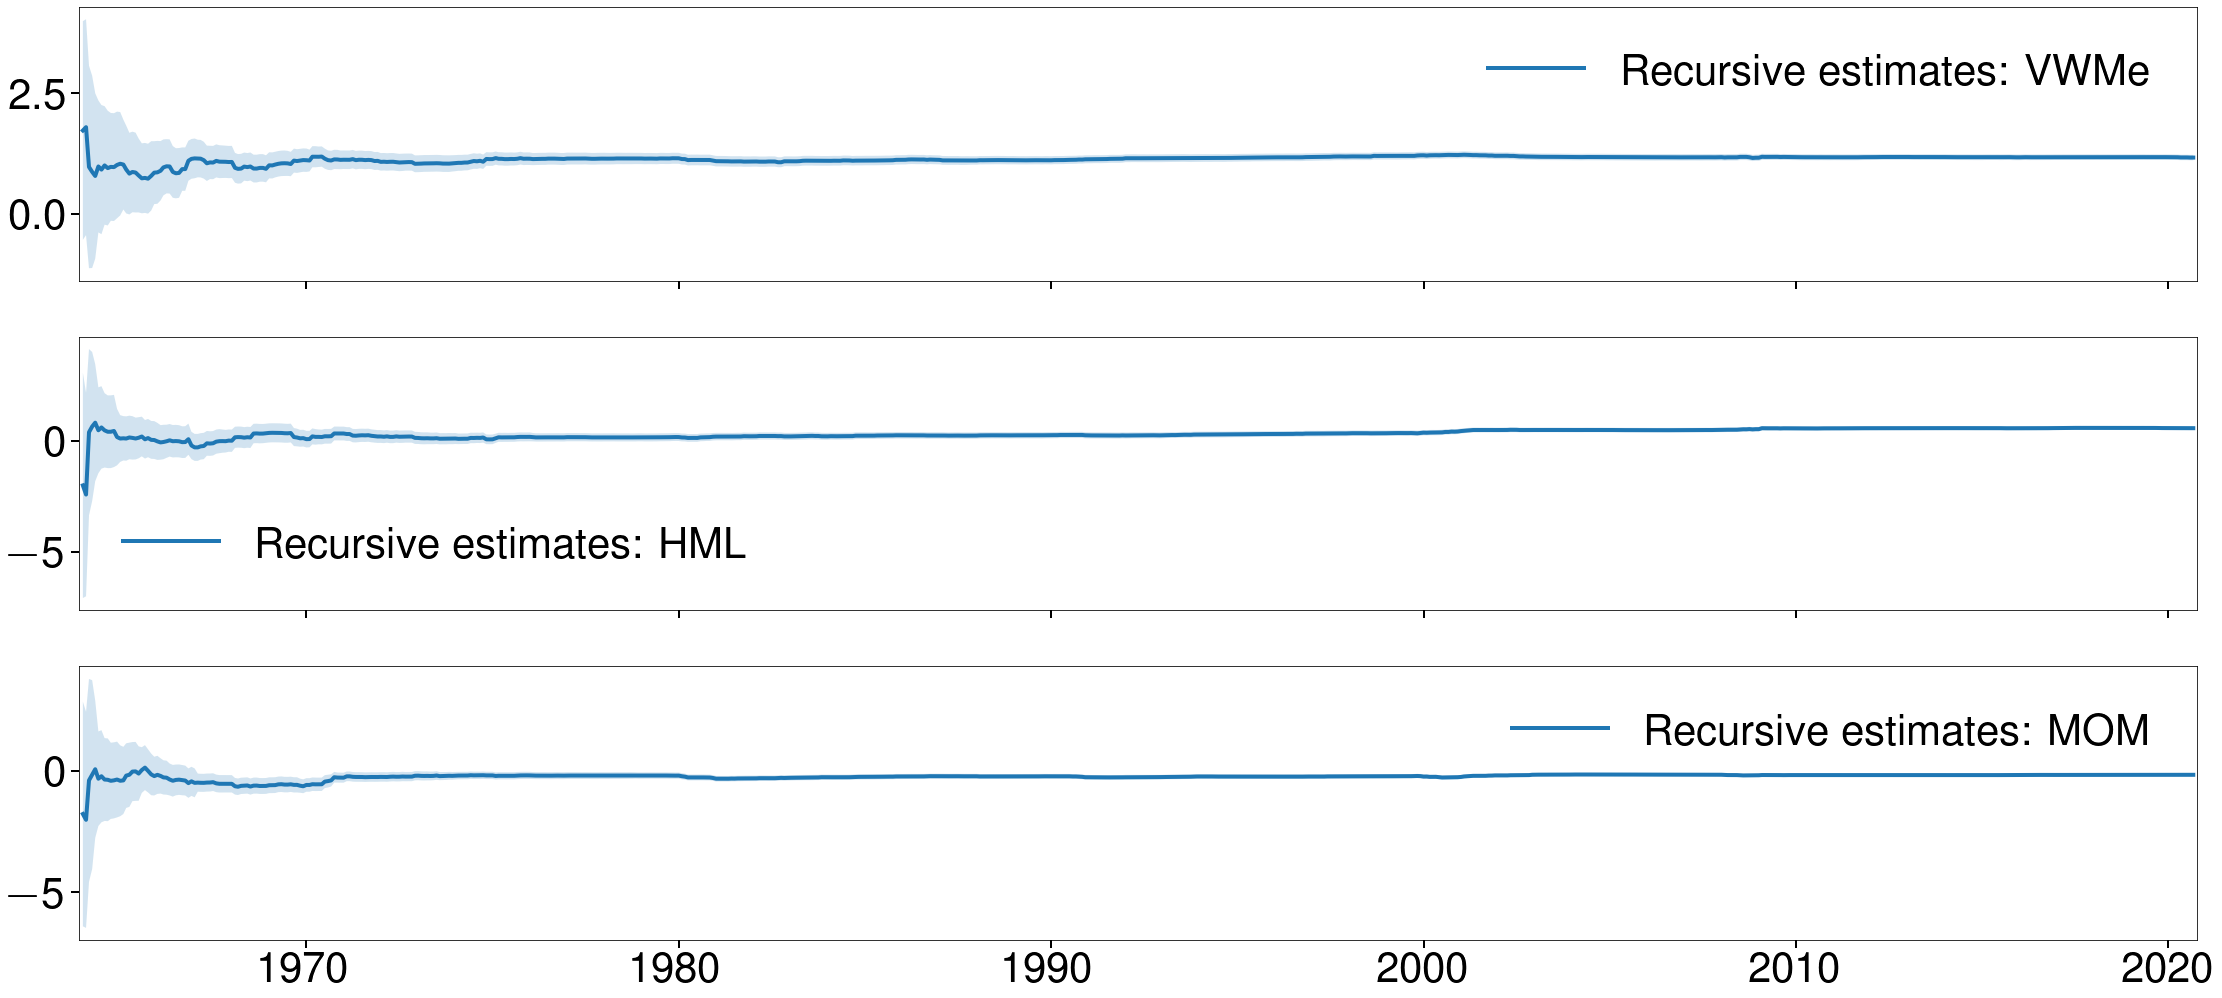

In [117]:
recursive_plot()

# Specification Testing
## Residual Plots: Residual vs $X$

* Residual plots are simple method to detect visible misspecification


In [118]:
def plot_residual():
    fig, ax = plt.subplots(2, 2)
    res = smf.ols("Clths ~ 1 + VWMe", data).fit()
    cols = ["VWMe", "SMB", "HML", "MOM"]
    for i in range(4):
        ix, iy = i % 2, i // 2
        temp = pd.concat([res.resid, data[cols[i]]], 1)
        temp.columns = ["$\hat{\epsilon}$", cols[i]]
        temp = temp.sort_values(cols[i])
        ax[ix, iy].plot(
            temp[cols[i]],
            temp.iloc[:, 0],
            linestyle="none",
            marker="o",
            color=mfe.colors[i],
        )
        ax[ix, iy].set_title(cols[i])
    fig.tight_layout(pad=1.0)

# Residual Plots: Residual vs  $X$ 

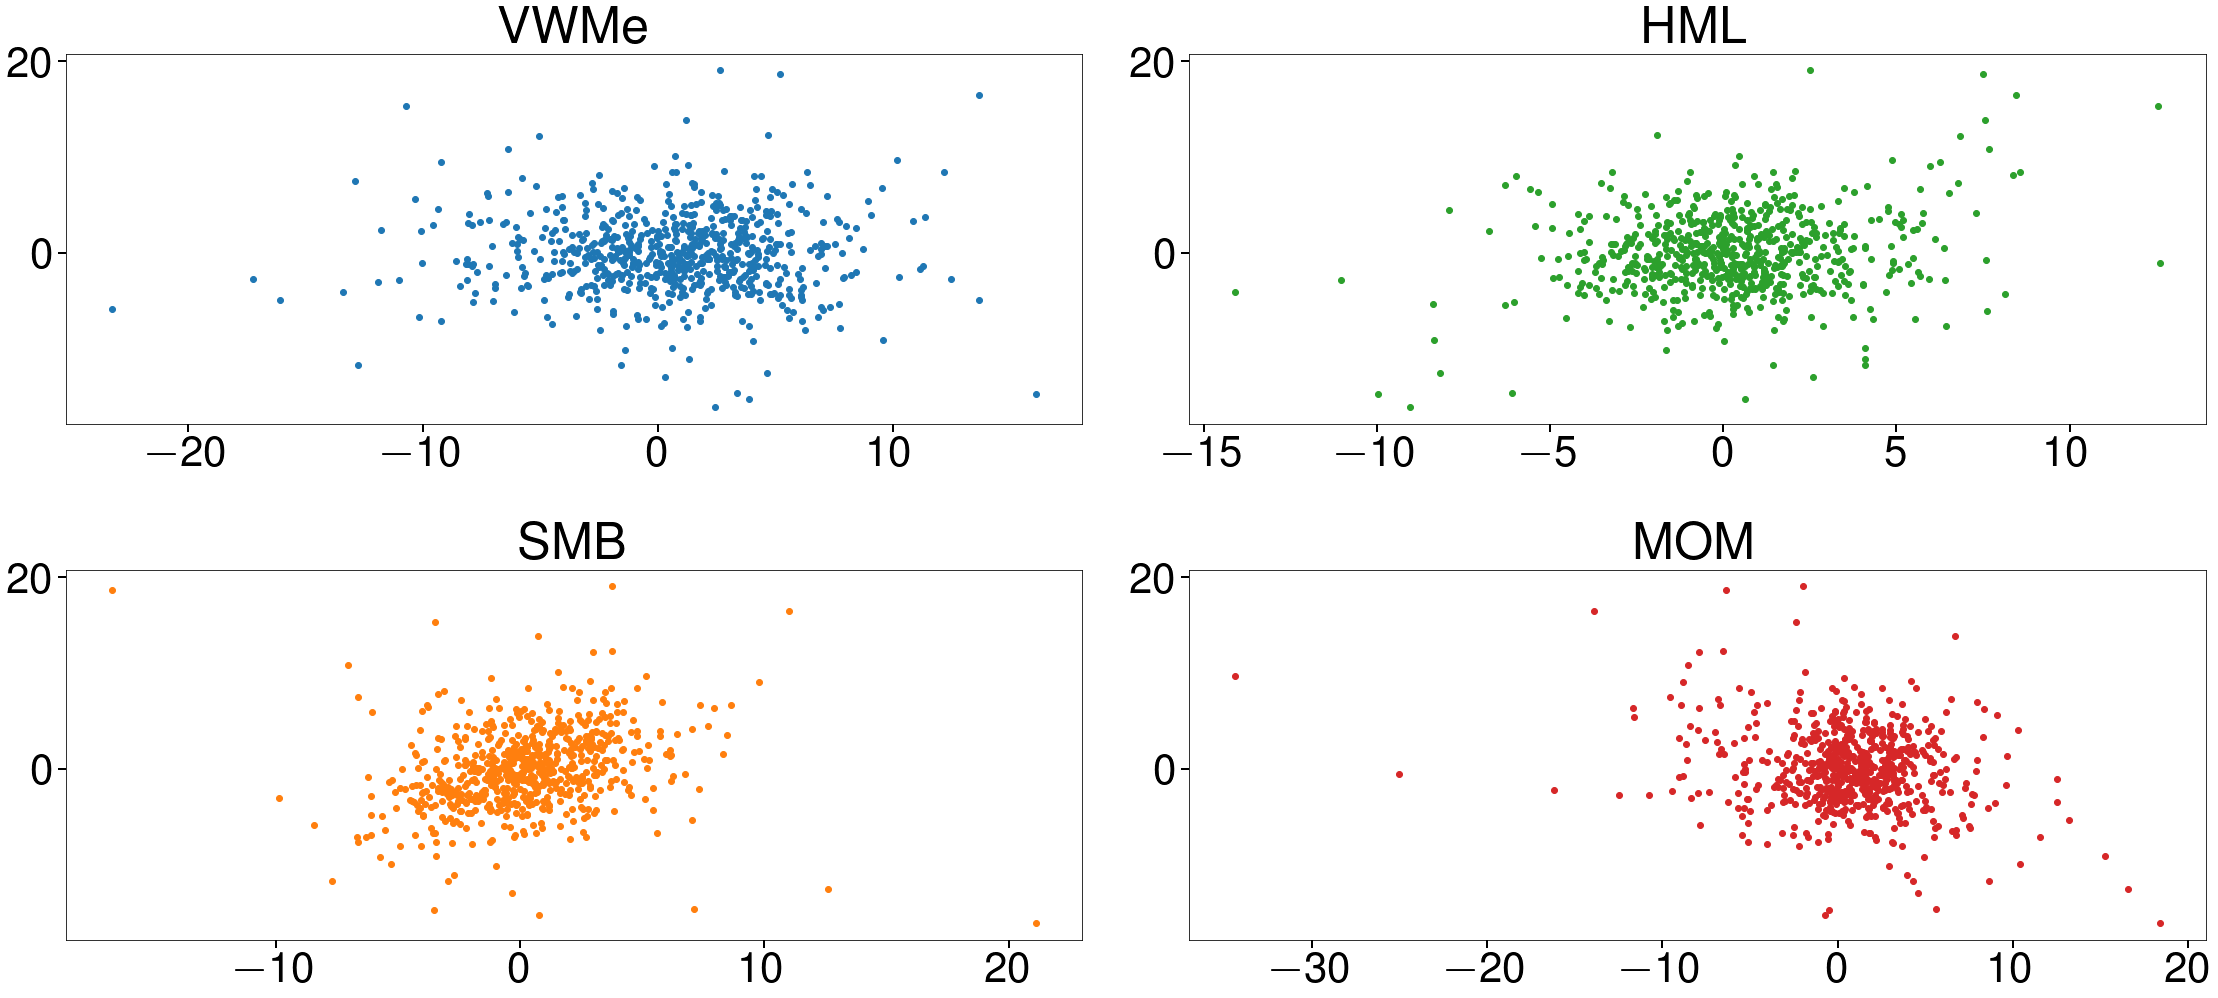

In [119]:
plot_residual()

# Specification Testing
## Residual Plots: Residual vs $X_i|X_1,X_2,\ldots,X_{i-1},X_{i+1},\ldots,X_k$

* Sometimes useful to plot residuals against regressors _partialed_ out
* Regress each regressor on the others included in the model
* Residual contains unique component of each regressor

In [120]:
def plot_partial_residual():
    fig, ax = plt.subplots(2, 2)
    res = smf.ols("Clths ~ 1 + VWMe", data).fit()
    cols = ["VWMe", "SMB", "HML", "MOM"]
    for i in range(4):
        ix, iy = i % 2, i // 2
        other_cols = cols[:]
        other_cols.remove(cols[i])
        partial = smf.ols(f"{cols[i]} ~ 1 + " + " + ".join(other_cols), data).fit()
        temp = pd.concat([res.resid, partial.resid], 1)
        temp.columns = ["$\hat{\epsilon}$", cols[i]]
        temp = temp.sort_values(cols[i])
        ax[ix, iy].plot(
            temp.iloc[:, 1],
            temp.iloc[:, 0],
            linestyle="none",
            marker="o",
            color=mfe.colors[i],
        )
        ax[ix, iy].set_title(cols[i])
    fig.tight_layout(pad=1.0)

# Partial Residual Plot

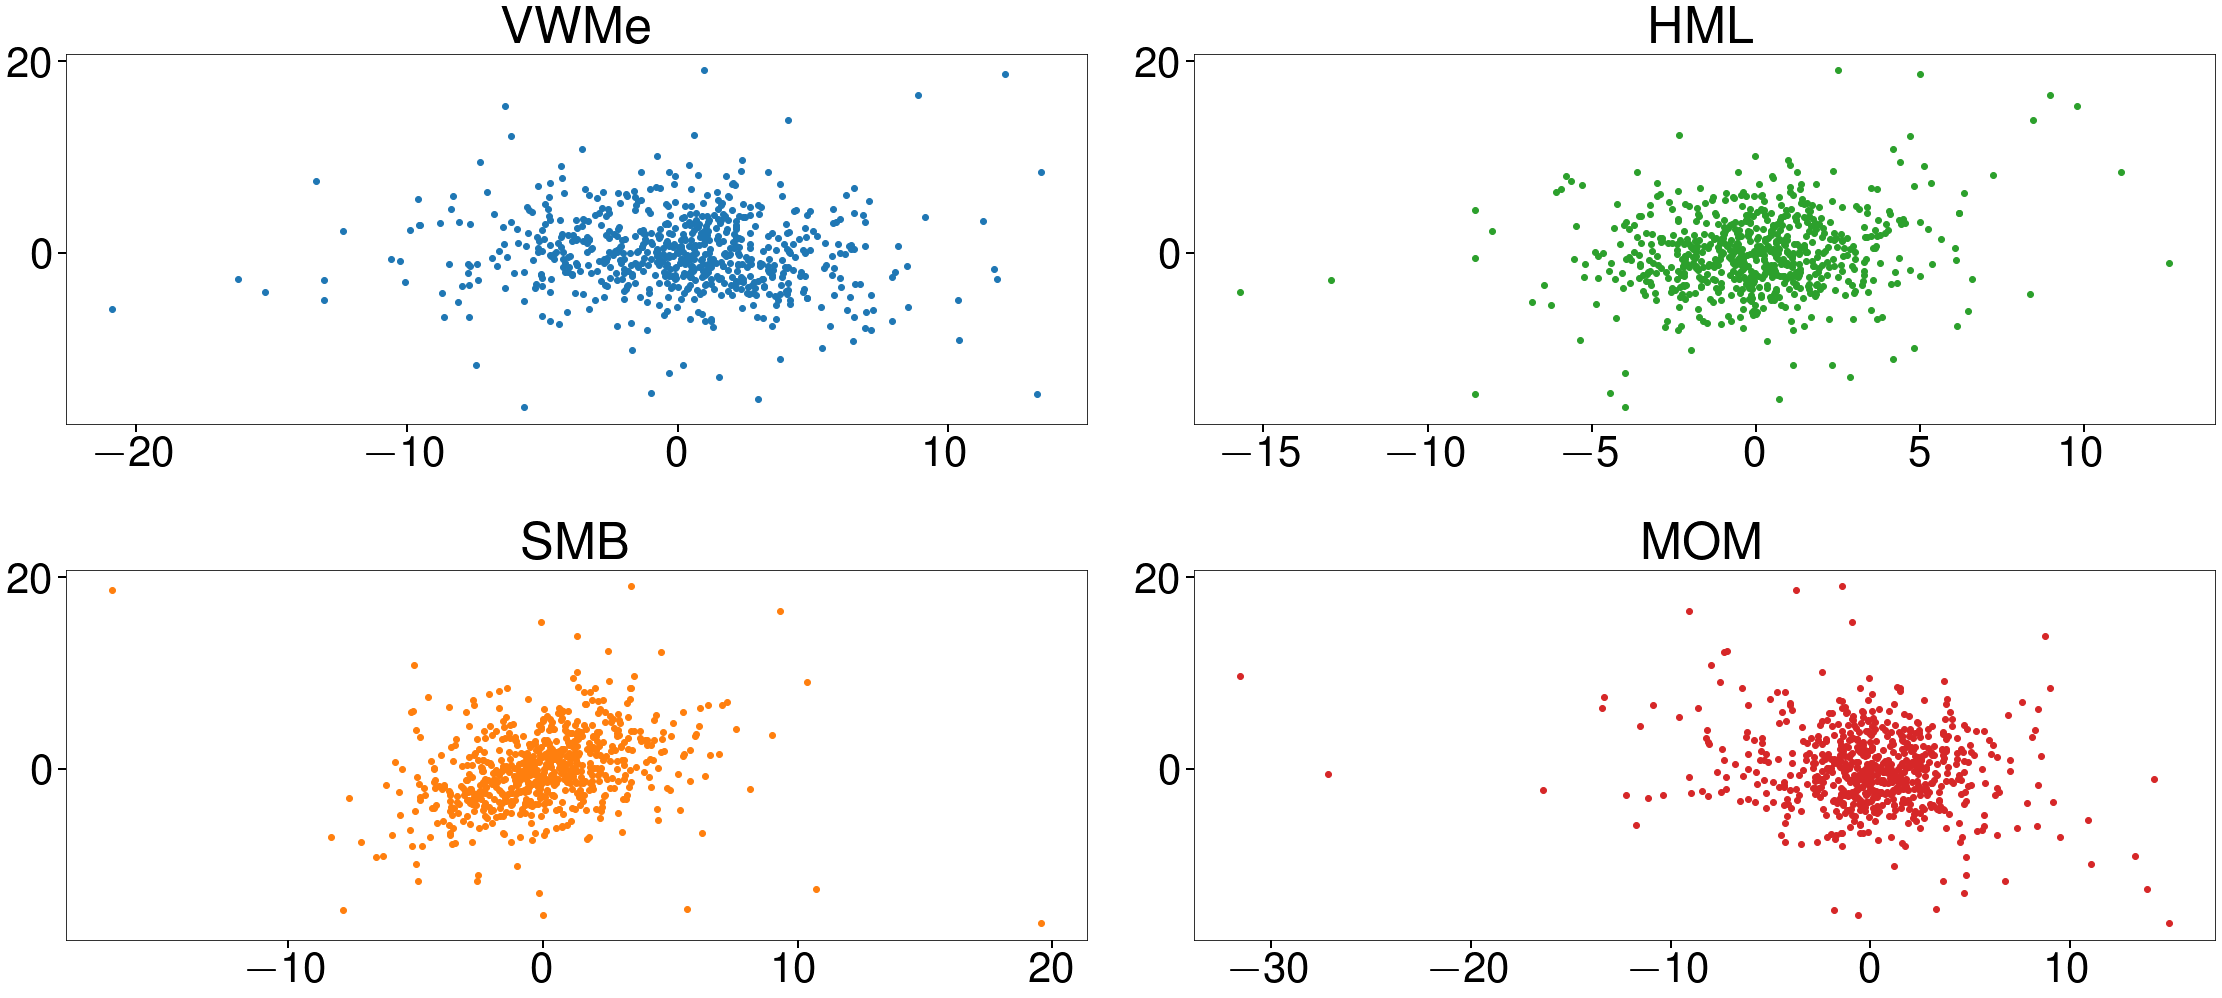

In [121]:
plot_partial_residual()

# Trimming
* Drop observations with large $\epsilon_i$
* Requires an initial estimator of $\boldsymbol{\beta}$
    * "Good" subset of data
    * Typical value in random subset
    * Robust estimator or LAD
* Remove observations with $\hat{\epsilon}_i$ below quantile $\alpha$ and above $1-\alpha$ for small $\alpha$ (1%, 2.5%, 5%)

In [122]:
lad = smf.quantreg("Oil ~ 1 + VWMe + SMB + HML + MOM", data).fit(q=0.5)
bounds = lad.resid.quantile([0.025, 0.975])
pretty(bounds)

,
0.025,-7.929285
0.975,8.650551


# Trimming

In [123]:
retain = (lad.resid > bounds.iloc[0]) & (lad.resid < bounds.iloc[1])
mod = "Oil ~ 1 + VWMe + SMB + HML + MOM"
trimmed = smf.ols(mod, data.loc[retain]).fit(cov_type="HC0")
summary(trimmed)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1302,0.141,-0.925,0.355,-0.406,0.146
VWMe,0.9070,0.038,23.716,0.000,0.832,0.982
SMB,-0.1617,0.055,-2.918,0.004,-0.270,-0.053
HML,0.3853,0.062,6.224,0.000,0.264,0.507
MOM,0.0567,0.039,1.448,0.148,-0.020,0.133


# Compare to OLS Estimates

In [124]:
full = smf.ols("Oil ~ 1 + VWMe + SMB + HML + MOM", data).fit(cov_type="HC0")
summary(full)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1240,0.172,-0.722,0.470,-0.461,0.213
VWMe,0.9537,0.053,17.951,0.000,0.850,1.058
SMB,-0.1525,0.065,-2.335,0.020,-0.281,-0.024
HML,0.3944,0.089,4.414,0.000,0.219,0.569
MOM,0.0609,0.050,1.218,0.223,-0.037,0.159


# Windsorization

* Similar to trimming with one key difference
* Replace large $\epsilon_i$ with their quantile
* No data dropped


In [125]:
data["Windsorized"] = data.Oil
predicted = lad.predict()
low = lad.resid < bounds.iloc[0]
data.loc[low, "Windsorized"] = predicted[low] + bounds.iloc[0]
high = lad.resid > bounds.iloc[1]
data.loc[high, "Windsorized"] = predicted[high] + bounds.iloc[1]
mod = "Windsorized ~ 1 + VWMe + SMB + HML + MOM"
windsorized = smf.ols(mod, data).fit(cov_type="HC0")
summary(windsorized)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.1163,0.154,-0.755,0.451,-0.419,0.186
VWMe,0.9225,0.042,21.844,0.000,0.840,1.005
SMB,-0.1519,0.059,-2.568,0.010,-0.268,-0.036
HML,0.3700,0.069,5.389,0.000,0.235,0.505
MOM,0.0564,0.043,1.303,0.193,-0.028,0.141
